# **Exploring Hurricane Tracks**

In this notebook, we reproduce some of the analysis carried out in "Classifying North Atlantic tropical cyclone tracks by mass moments." Journal of Climate 22.20 (2009): [5481-5494](https://journals.ametsoc.org/configurable/content/journals$002fclim$002f22$002f20$002f2009jcli2828.1.xml?t:ac=journals%24002fclim%24002f22%24002f20%24002f2009jcli2828.1.xml) by Nakamura, Jennifer, et al.

This notebook (a Python-based JupyterNotebook) provides a set of starter codes for [LEAP CPC Spring 2025](https://github.com/leap-stc/LEAPCourse-Climate-Pred-Challenges) [**Project 1**](https://github.com/leap-stc/LEAPCourse-Climate-Pred-Challenges#project-cycle-1-individual-notebook-for-exploratory-data-analysis) on

+ how to work with x-array data (given the hurricane tracks data),
+ how to visualize tracks and their moments,
+ how to carry out basic analysis on the hurricane data,
+ how to do k-means with the moments based on the paper's original idea.

All the codes in this notebook can be modified to implement research ideas.  



- Github sharing is recommended.
    - See our Github [tutorial](https://github.com/leap-stc/LEAPCourse-Climate-Pred-Challenges/blob/main/Tutorials/Github-Tutorial.md).
    - If you need help, please reach out to TA Xinyi Ke xk2161@columbia.edu.




# Step 0: Setup workspace

In [1]:
import os
cwd=os.getcwd()

cwd_data=cwd+'/data'

if not os.path.exists(cwd_data):
    os.mkdir(cwd_data)


Setup a subfolder for downloaded raw data and another subfolder for outputs. This prevents you from overwrites raw data by accident.

You can check that this new folder called 'data' was created. To view the files in your workspace, click on the 'File Browser' buttom at the left side-bar.

This folder will be used to store data which will be later downloaded.

---



# Step 1: Install packages, import packages and download data


## 1.1 Packages

Download the required packges.

In [2]:
%%capture
# These uninstallation must be done to ensure that no version conflicts would happen.
!pip uninstall --yes cartopy
!pip uninstall --yes shapely
# Shapely and cartopy are used for graphing maps and tracks.
!pip install shapely cartopy
!pip install gender_guesser

In [3]:
import cartopy.crs as ccrs # used for map projection
import matplotlib.pyplot as plt # matplotlib
import cartopy.feature as cfeature # used for map projection
import xarray as xr # x-array
import numpy as np # numpy
import urllib.request # download request
import warnings # to suppress warnings
import gender_guesser.detector as gender # for analyzing the names of hurricanes
from numpy import linalg as LA # to plot the moments (by calculating the eigenvalues)
from sklearn.cluster import k_means # to perform k-means
from collections import Counter # set operations
warnings.filterwarnings('ignore')

## 1.2 Load Hurricane Data

Useful links to read more about data:

* [Official website for IBTrACS](https://www.ncdc.noaa.gov/ibtracs/). (where the data comes from)

* [Tracks in other basins for IBTrACs (other than NA)](https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/) (The data downloaded below covers the tracks in the basin 'NA' (North America). So, if you want to study tracks or hurricanes from other basins, this link might be helpful.)

* Another source of data: [HURDAT2](https://oasishub.co/dataset/hurdat-2-atlantic-hurricane-database/resource/2c865c53-3fc3-4e16-9ef5-0d76a47cfcf3) (not used in this notebook, but might be useful)



*   General documentation of the data: https://www.ncdc.noaa.gov/ibtracs/pdf/IBTrACS_version4_Technical_Details.pdf
*   Detailed documentation on each variable(this is particularly helpful if you want to dig more into the dataset and find what problems you are interested in solving regarding the track data): https://www.ncdc.noaa.gov/ibtracs/pdf/IBTrACS_v04_column_documentation.pdf


In [4]:
import requests

# IBTrACS.NA.v04r00.nc presents data from 1842-10-25 through 2023-06-07 
url = 'https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.NA.v04r00.nc'
output_file = 'data/NA_data.nc'

try:
    response = requests.get(url, timeout=60)
    response.raise_for_status()  # Raise an error for HTTP codes >= 400
    with open(output_file, 'wb') as f:
        f.write(response.content)
    print("File downloaded successfully.")
except requests.exceptions.RequestException as e:
    print(f"Request failed: {e}")


File downloaded successfully.


In [5]:
# Download the needed track file
filedata = urllib.request.urlopen('https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.NA.v04r00.nc')

datatowrite = filedata.read()

with open('data/NA_data.nc', 'wb') as f:   
    f.write(datatowrite)

Now, check the /data directory (left panell( to see if the data `NA_data.nc` has been saved there.

# Step 2: Visualization of hurricane tracks






In this section, the notebooks give examples on how to plot tracks on a map on locations specified by users.

All the codes in this section can be directly used or modified to allow more features in later works.

## 2.1 Map background

This function plots a background map with parameters label and extent.



*   **label**: boolean, to short label or not on the output map background
*   **extent**: this controls where the projection appears, i.e., which part of earth map should appear on the projection. Its four entries can be viewd as (starting_longitude, ending_longitude, starting_latitude, ending_latitude).



In [6]:
def map_background(label=False, extent=[-100, 0, 0, 60]):
  # A helpder function for creating the map background.
  # INPUT:
  # "extent": corresponds to the location information of the showed map.
  # "label": boolean

  # OUTPUT:
  # Matplotlib AXES object

  plt.figure(figsize = (20, 10))
  ax = plt.axes(projection=ccrs.PlateCarree())
  ax.coastlines()
  ax.set_extent(extent)
  ax.gridlines(draw_labels=label) # show labels or not
  LAND = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                      edgecolor='face',
                                      facecolor=cfeature.COLORS['land'],
                                          linewidth=.1)
  OCEAN = cfeature.NaturalEarthFeature('physical', 'ocean', '10m',
                                       edgecolor='face',
                                       facecolor=cfeature.COLORS['water'], linewidth=.1)
  ax.add_feature(LAND, zorder=0)
  ax.add_feature(OCEAN)
  return ax

## 2.1.1 A simple example using the function.

Here, we plot a line between two Stanford and Berkeley using the above function.

Text(-122.1461, 37.4041, 'Stanford')

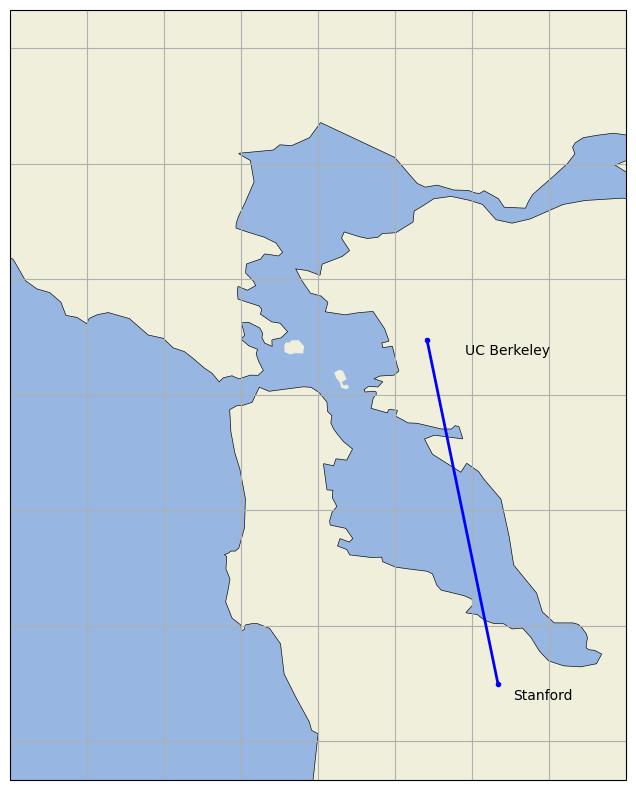

In [7]:
ax = map_background(extent=[-122.8, -122, 37.3, 38.3])

berkeley_lon, berkeley_lat = -122.2585, 37.8719
stanford_lon, stanford_lat = -122.1661, 37.4241

# plot the two universities as blue dots
ax.plot([berkeley_lon, stanford_lon], [berkeley_lat, stanford_lat],
         color='blue', linewidth=2, marker='.')
ax.text(berkeley_lon + 0.16, berkeley_lat - 0.02, 'UC Berkeley',
         horizontalalignment='right')
ax.text(stanford_lon + 0.02, stanford_lat - 0.02, 'Stanford',
         horizontalalignment='left')

\\

---

\\

## 2.2 Working with xarray data.

+ [Xarray documentation](https://xarray.pydata.org/en/stable/user-guide/terminology.html).
+ Read more about [data](https://earth-env-data-science.github.io/lectures/data.html).

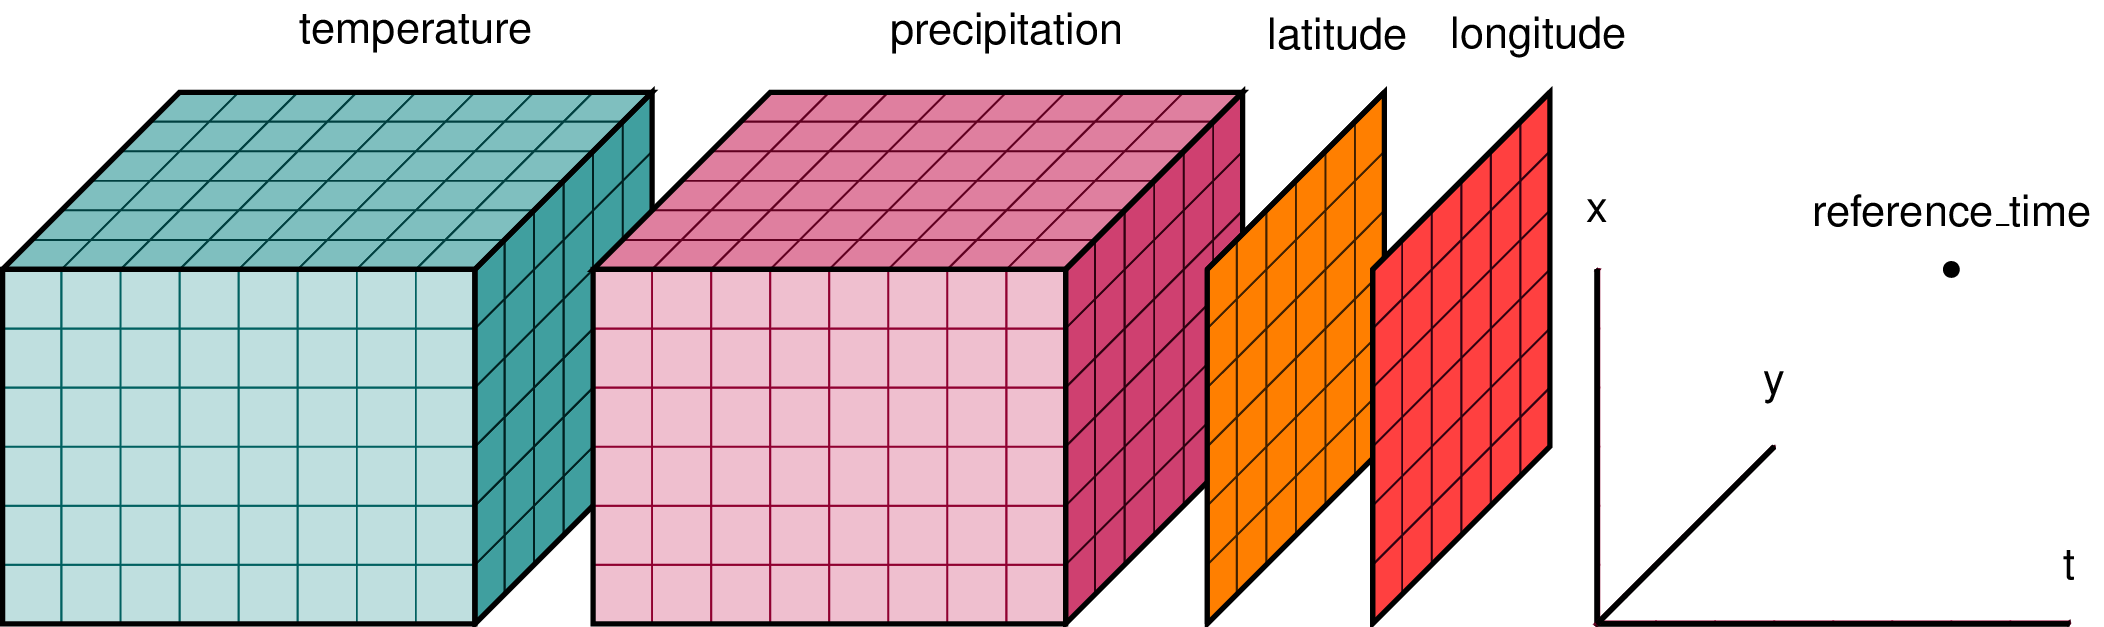


Even though the graph above has nothing to with the paper, the diagram (taken from x-array documentation website) illustrates the structure of xarray data (a Dataset in this case) works. In this example, we have the **axis** (x, y, t), **data** (temperature, precipitation, y, x). The latitude (y) and longitude (x) label the points along the dimensions, so they are the 'coordinate_data', while temperature and precipitation are 'actual' variables in a dataset. The latitude and longitude are 2D data in this case because the example used map projection. There can be an infinite amount of variables, but it would be unwise to have lots of axes and coordinates.

### 2.2.1 Explore the dataset of hurricanes and related systems

Run the code below to see an example of information that can be obtained from the original data.\
Read the output of the following code chunks to see some examples of operations we can carry out on the dataset.

In [8]:
tks = xr.open_dataset('data/NA_data.nc', engine="netcdf4", decode_times=False)

## Print the tks to take a peek at what's actually in the dataset.
print(tks)

<xarray.Dataset> Size: 618MB
Dimensions:           (storm: 2344, date_time: 360, quadrant: 4)
Coordinates:
    time              (storm, date_time) float64 7MB ...
    lat               (storm, date_time) float32 3MB ...
    lon               (storm, date_time) float32 3MB ...
Dimensions without coordinates: storm, date_time, quadrant
Data variables: (12/147)
    numobs            (storm) float32 9kB ...
    sid               (storm) |S13 30kB ...
    season            (storm) float32 9kB ...
    number            (storm) int16 5kB ...
    basin             (storm, date_time) |S2 2MB ...
    subbasin          (storm, date_time) |S2 2MB ...
    ...                ...
    reunion_gust      (storm, date_time) float32 3MB ...
    reunion_gust_per  (storm, date_time) float32 3MB ...
    usa_seahgt        (storm, date_time) float32 3MB ...
    usa_searad        (storm, date_time, quadrant) float32 14MB ...
    storm_speed       (storm, date_time) float32 3MB ...
    storm_dir         (storm,

All the **coordinates** and **data variables** must align along the dimensions. **Attributes**, however, doesn't have to have shapes that aligned with at least one of the axes. It serves as a more auxiliary role in the dataset and provide other information that might be helpful.\
To obtain any variable from the dataset, for example 'xxx', use ***tks.xxx***.

In [9]:
# for example, Storm_speed
tks.storm_speed

<xarray.DataArray 'storm_speed' (storm: 2344, date_time: 360)> Size: 3MB
[843840 values with dtype=float32]
Coordinates:
    time     (storm, date_time) float64 7MB ...
    lat      (storm, date_time) float32 3MB ...
    lon      (storm, date_time) float32 3MB ...
Dimensions without coordinates: storm, date_time
Attributes:
    long_name:              Storm translation speed
    units:                  kts
    valid_min:              0
    valid_max:              998
    coverage_content_type:  physicalMeasurement

In [10]:
## how many tracks in total, this is the same as the length of the dimension 'storm'
storm_num = tks.dims['storm']

## Note that the dimension 'quadrant' is often not used, which can be
## dropped if wanted by tks.drop_dims("quadrant")
print(f"\nDimension of the dataset is {dict(tks.dims)}")
print(f"\nIn total, there are {storm_num} track records.")
print(f"\nThe attributes of this dataset are:\n {list(tks.attrs.keys())}")


## starting and ending season (the same as year)
min_year = np.array(np.min(list(tks.season)), dtype=int)
max_year = np.array(np.max(list(tks.season)), dtype=int)

print(f"\nTrack records start in year {min_year} and ends in year {max_year}")

## Print all the variables in a list.
print('\nAll variables in this dataset:')
print(list(tks.keys()))


## Print a sentence that contians some summary information.
storm_1 = tks.sel(storm=2000) # notice that the first storm starts with 0 not 1
name = str(storm_1.name.values)[2:-1] # use this trick to obtain the name string
sid = str(storm_1.sid.values,'UTF-8')
print(f"\nThe 2001st hurricane, named {name}, has a record of {int(storm_1.numobs)} \
observations with sid {sid} in year {int(storm_1.season)}.")


Dimension of the dataset is {'storm': 2344, 'date_time': 360, 'quadrant': 4}

In total, there are 2344 track records.

The attributes of this dataset are:
 ['title', 'summary', 'source', 'Conventions', 'Conventions_note', 'product_version', 'project', 'processing_level', 'acknowledgement', 'references', 'institution', 'publisher_type', 'publisher_name', 'publisher_email', 'publisher_institution', 'publisher_url', 'creator_type', 'creator_name', 'creator_institution', 'creator_email', 'creator_url', 'contributor_name', 'contributor_role', 'date_created', 'date_issued', 'time_coverage_start', 'time_coverage_end', 'geospatial_lat_min', 'geospatial_lat_max', 'geospatial_lat_units', 'geospatial_lat_resolution', 'geospatial_lon_min', 'geospatial_lon_max', 'geospatial_lon_units', 'geospatial_lon_resolution', 'geospatial_vertical_min', 'geospatial_vertical_max', 'naming_authority', 'id', 'metadata_link', 'keywords', 'keywords_vocabulary', 'standard_name_vocabulary', 'history', 'license', 'fea

\\

---

\\

## 2.3 Visualizing a track or group of tracks

We use asterisk and X to denote the birth and death points of a track.

In [11]:
# These are helper functions to conveniently plot one single track.
def get_lon_lat(storm):
  lon_lst = storm.lon.values
  lat_lst = storm.lat.values
  return lon_lst[~np.isnan(lon_lst)], lat_lst[~np.isnan(lat_lst)]

# !!! Note that even though it's a convention to place latitude before longitude,
# to work with cartopy projection, longitude MUST be placed first. !!!
def plot_one_track(ax, storm, color='blue', all_track=True, marker_color='black'):
  # INPUT:
  # ax: Matplotlib axes object
  # storm: a Xarray DATASET object (this can be adjusted if desired)
  # all_track: plot the whole track or just the origin

  # OUTPUT:
  # None

  lon_lst, lat_lst = get_lon_lat(storm)
  year = storm.season.values
  if all_track:
    ax.plot(lon_lst, lat_lst, '-o', color=color, linewidth=2, markersize=3) # marker='.'
    ax.plot(lon_lst[-1], lat_lst[-1], color=marker_color, marker='x', markersize=10)
  ax.plot(lon_lst[0], lat_lst[0], color=marker_color, marker='*', markersize=10)
  ax.text(lon_lst[0], lat_lst[0]-2, str(storm.name.values)[2:-1], horizontalalignment='center')



## 2.3.1 Visualize all tracks in a year


Use function to visualize all tracks in year 2017 (or whichever year you choose on first line)

There are 19 storms in the year 2017.



Text(0.5, 1.0, 'Tracks in year 2017')

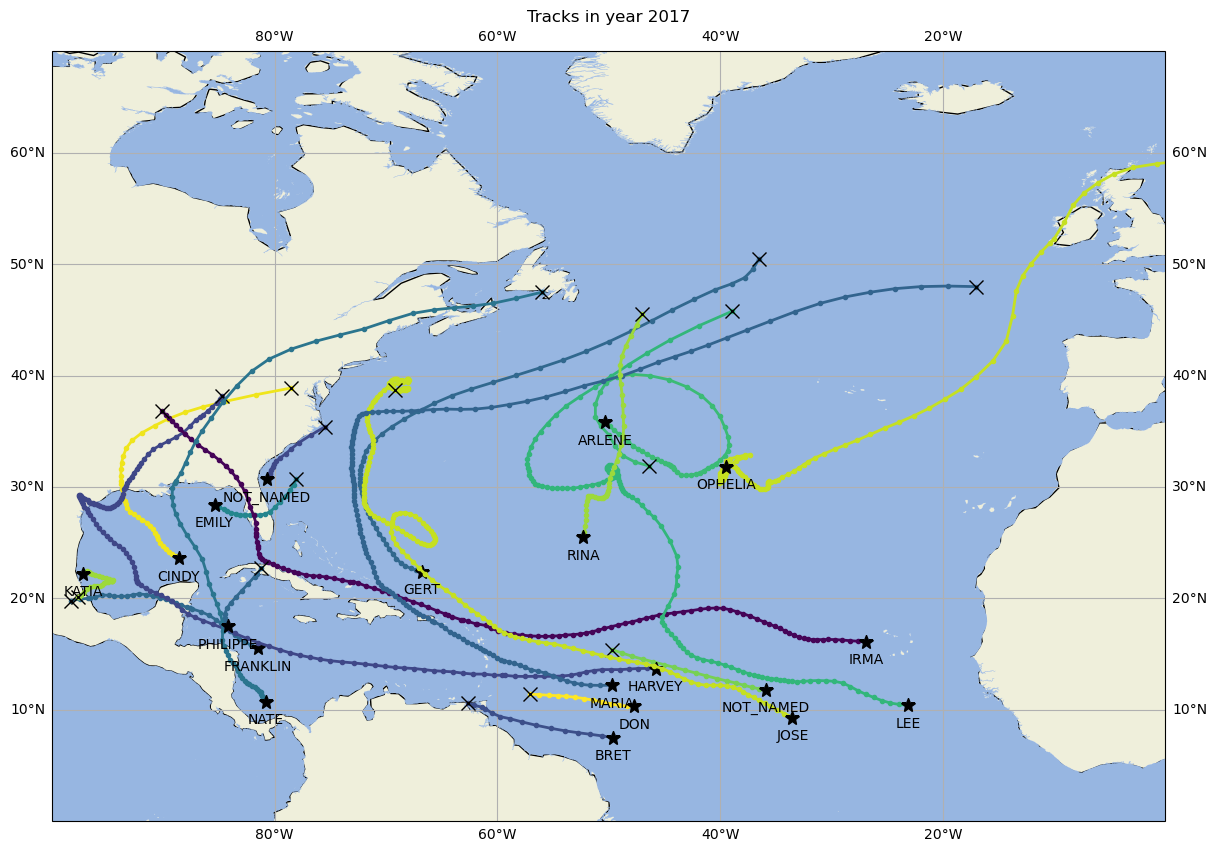

In [12]:
year=2017 # Change this to see tracks from other years.
storms = tks.where(tks.season==year, drop=True) # select the hurricanes that happened in selected year
print(f"There are {storms.dims['storm']} storms in the year {year}.\n")
storm_num = storms.dims['storm']
ax = map_background(extent=[-100, 0, 0, 60], label=True)
cmap = plt.get_cmap("viridis")

for ind in range(storm_num):
  storm = storms.sel(storm=ind)
  # Generate a random value between 0 and 1
  value = np.random.rand()
  # Get the color corresponding to the random value
  color = cmap(value)
  plot_one_track(ax, storm, color=color)
    
plt.title(f"Tracks in year {year}")
# plt.legend()

\\

---

\\

# Step 3: Analyze Tracks

Here we use moment as a numerical characteristic of a track. [Ophelia (2005)](https://en.wikipedia.org/wiki/Hurricane_Ophelia_(2005)) is given as an example track.



## 3.1 Define the moments of a track

Below codes plot ONE track and its moments based on the paper's idea.

So, what we want to do here is to find a summary statistics for the track. Here the method below calculates the weighted first and second moments of a track, which would ouput a 5-entry vector which can be used in clustering and analysis purpose.

M1 here stands for the first moment. When the weights $w$ are set to 1, it simply calculating the means of the longitude and latitude vectors. Changing the weights to other variables, such as wind speed, storm speed, temperatures, etc. should result in different clustering. In the paper, setting all the weights to 1 is used.

M2 stands for the second moment. When the weights are 1, it is calculating the variances and covariance of longitude and latitude vectors of a given track.

$r$ is a two-dimensional vector that corresponds to $(x,y)$, i.e., longitude and latitude.

See [Nakamura et al (2009)](https://journals.ametsoc.org/configurable/content/journals$002fclim$002f22$002f20$002f2009jcli2828.1.xml?t:ac=journals%24002fclim%24002f22%24002f20%24002f2009jcli2828.1.xml) for more details on the notation.

$$
\begin{aligned}
\mathbf{M 1}&=\frac{1}{A} \int w(\mathbf{r}) \mathbf{r} d x d y=\frac{1}{\sum_{i=1}^{n} w\left(r_{i}\right)} \sum_{i=1}^{n} w\left(\mathbf{r}_{i}\right) \mathbf{r}_{i} \\
\mathbf{M 2} &=\frac{1}{A} \int w(\mathbf{r})(\mathbf{r}-\mathbf{M 1})^{2} d x d y
=\frac{1}{\sum_{i=1}^{n} w\left(r_{i}\right)} \sum_{i=1}^{n} w\left(\mathbf{r}_{i}\right)\left(\mathbf{r}_{i}-\mathbf{M 1}_{i}\right)^{2}
\end{aligned}
$$


## 3.1.1 Function to calculate moment for a system

This function outputs a length-5 vector that summaries the moments of a track as specified in the above description.


In [13]:
def get_moments(storm):
  # A function to calculate the track moments given a storm
  # OUTPUT:
  # X-centroid, Y-centroid, X_var, Y_var, XY_var

  # Note that:
  # In this case, no weights are set. In other words, all weights are 1.
  # A weight variable would need to be added in order to explore other weights

  lon_lst, lat_lst = get_lon_lat(storm)
  # If the track only has one point, there is no point in calculating the moments
  if len(lon_lst)<= 1: return None
      
  # M1 (first moment = mean). 
  # No weights applied
  lon_weighted, lat_weighted = np.mean(lon_lst), np.mean(lat_lst)
    
  # M2 (second moment = variance of lat and of lon / covariance of lat to lon
  # No weights applied
  cv = np.ma.cov([lon_lst, lat_lst])
    
  return [lon_weighted, lat_weighted, cv[0, 0], cv[1, 1], cv[0, 1]]

## 3.1.2 Calculate moments and visualize for one system

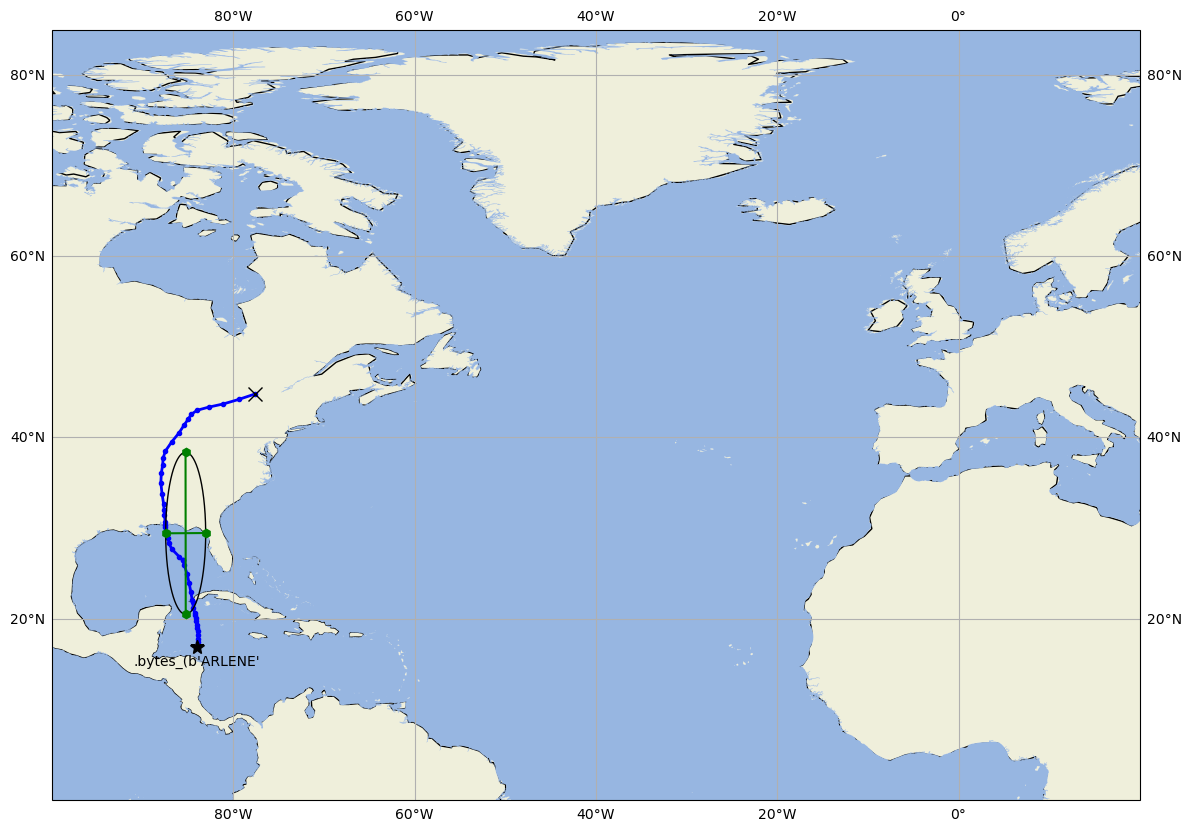

In [14]:
storm = tks.sel(storm=2000)
lon_weighted, lat_weighted, lon_var, lat_var, xy_var = get_moments(storm)

# Rotate the circle and calculate points on the circle
# Set N larger to make the oval more precise and to consume more electricity
N=1000
t = np.linspace(0, 2 * np.pi, N)
circle = [np.sqrt(lon_var) * np.cos(t), np.sqrt(lat_var) * np.sin(t)]
_, R_rot = LA.eig(np.array([[lon_var, xy_var], [xy_var, lat_var]]))
circle = np.dot(R_rot, circle)
R_1, R_2 = circle[0, :] + lon_weighted, circle[1, :] + lat_weighted

# Plot
ax = map_background(extent=[-100, 20, 0, 80], label=True)
plot_one_track(ax, storm)
ax.plot(R_1, R_2, '-', color='black', linewidth=1)
ax.plot([circle[0,0], circle[0,int(N/2)]]+lon_weighted,
        [circle[1,0], circle[1,int(N/2)]]+lat_weighted, '-gh')
ax.plot([circle[0,int(N/4)], circle[0,int(N*3/4)]]+lon_weighted,
        [circle[1,int(N/4)], circle[1,int(N*3/4)]]+lat_weighted, '-gh')

## 3.2 K-means clustering using moments for all systems

In this section, K-means clustering is carried out on the historical tracks with the idea adopted from the paper. As the data are different, nuances with the clustering results are expected.

In [15]:
# It takes a moment to calculate the moments.
moment_lst = [get_moments(tks.sel(storm=i)) for i in range(tks.dims['storm'])
              if get_moments(tks.sel(storm=i))]
print(np.shape(moment_lst))
print(f"There are {tks.dims['storm']-np.shape(moment_lst)[0]} tracks that have length less than 1.")

(2315, 5)
There are 29 tracks that have length less than 1.


### 3.2.1 Find inertia values to determine the right number of clusters

Run the clustering for a range of cluster numbers and extract the interia value

Inertia values from sklearn are evaluated with the "elbow method" to determine the optimal value of the clusters.\
Inertia, or cost, is calculated as the sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided. See the documentation for [sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) for more details.

Text(0.5, 1.0, 'Inertia Values against the Number of Cluster k')

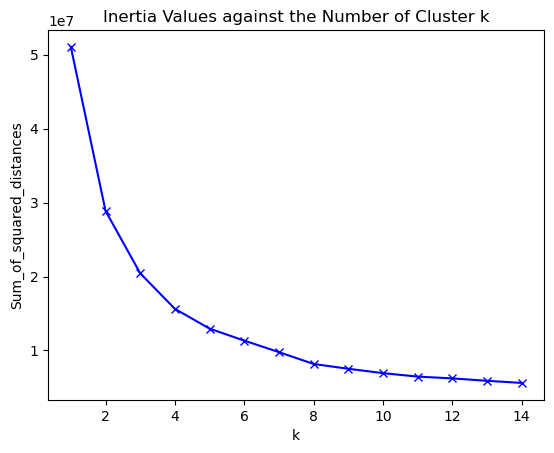

In [16]:
sum_of_squares = []
K = range(1, 15)
for k in K:
    km = k_means(moment_lst, n_clusters=k)
    sum_of_squares.append(km[2])
plt.plot(K, sum_of_squares, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Inertia Values against the Number of Cluster k')

From the plot above, 6 is probably a good choice for the number of clusters.\
Below codes plot the K-means results. The locations on the map are the weighted first moment of the hurricane tracks. In the example code, the weights were set to be 1 meaning that the first moment is the sample mean (see section 3.1 description).

Note that if you run the code again the ordering of the clusters changes

Text(0.5, 1.0, 'K-means clustering result, 6 clusters')

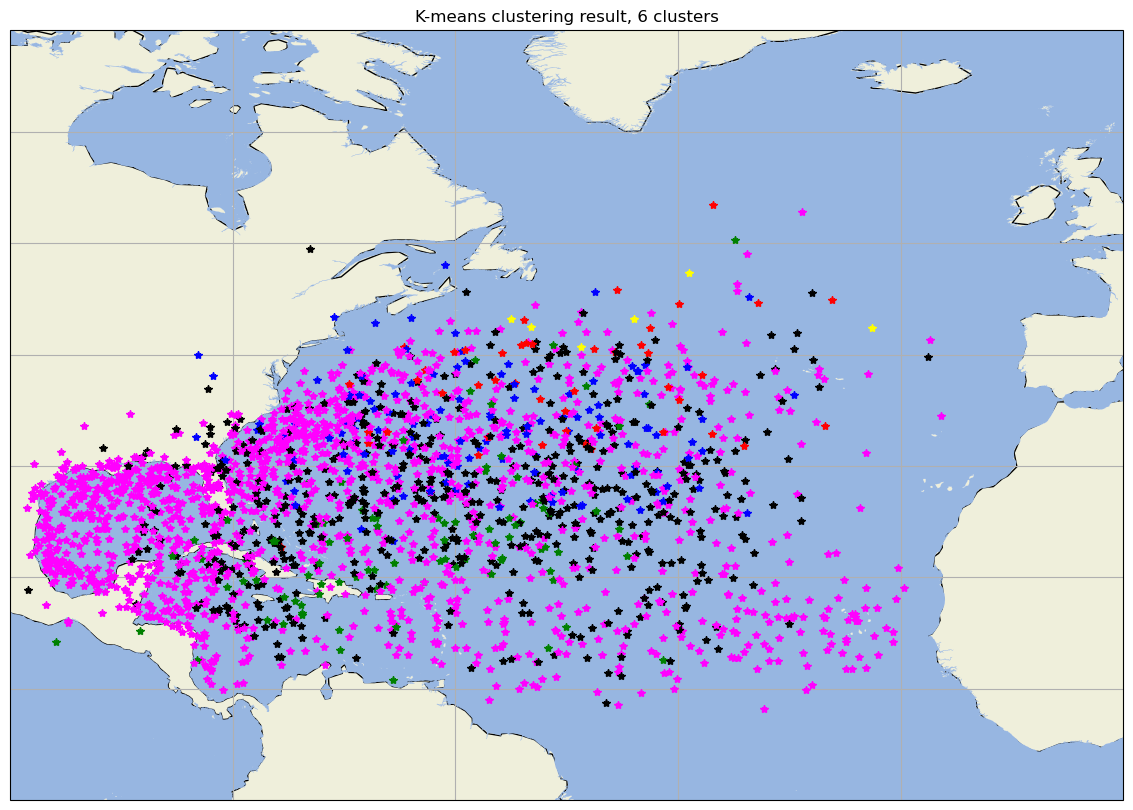

In [17]:
km = k_means(moment_lst, n_clusters=6)
# print(km[0])

colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta']
labels = km[1]
ax = map_background()
for k in range(len(moment_lst)):
    ax.plot(moment_lst[k][0], moment_lst[k][1], c=colors[labels[k]], marker='*')
plt.title('K-means clustering result, 6 clusters')

Text(0.5, 1.0, 'K-means clustering result')

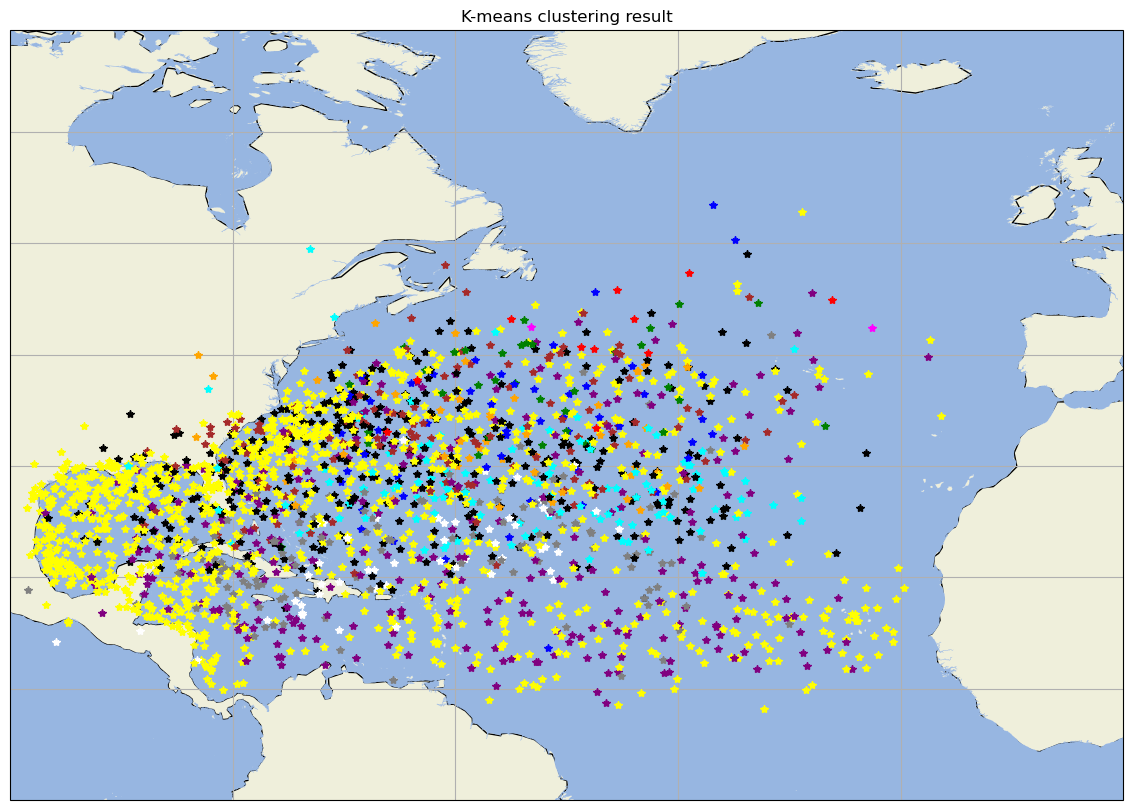

In [18]:
# consider a different number of clusters (colors set for up to 12, add more colors if you want more clusters)
km = k_means(moment_lst, n_clusters=12)
# print(km[0])

colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta','orange','gray','white','cyan','purple','brown']
labels = km[1]
ax = map_background()
for k in range(len(moment_lst)):
    ax.plot(moment_lst[k][0], moment_lst[k][1], c=colors[labels[k]], marker='*')
plt.title('K-means clustering result')

## 3.5 Other Summary Statistics and example comparisons

### 3.5.1 Distance traveled

Compare the $\Delta$ lon and $\Delta$ lat between these two interval of years (2000\~2010 against 1990\~1999).\
$\Delta$ lon is the maximum value of distance of travel of a hurricane from its start to its end location in its longitude (same as the what [np.ptp](https://numpy.org/doc/stable/reference/generated/numpy.ptp.html) does).

194 storms between year 2000 and 2010,         133 storms between year 1990 and 1999.



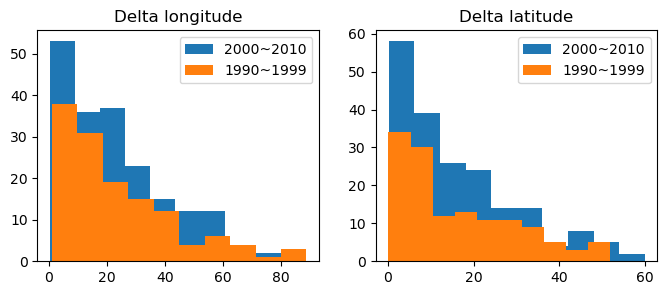

In [19]:
def delta_lon_lat(storm):
  lon_lst, lat_lst = get_lon_lat(storm)
  return [np.ptp(lon_lst), np.ptp(lat_lst)]

storms_1 = tks.where((tks.season >= 2000) & (tks.season <= 2010), drop=True)
storms_2 = tks.where((tks.season >= 1990) & (tks.season <= 1999), drop=True)
N1, N2 = storms_1.dims['storm'], storms_2.dims['storm']
print(f"{storms_1.dims['storm']} storms between year 2000 and 2010, \
        {storms_2.dims['storm']} storms between year 1990 and 1999.\n")

d_lst_1 = [delta_lon_lat(storms_1.sel(storm=i)) for i in range(N1)]
d_lst_1 = np.transpose(d_lst_1)

d_lst_2 = [delta_lon_lat(storms_2.sel(storm=i)) for i in range(N2)]
d_lst_2 = np.transpose(d_lst_2)


fig, axs = plt.subplots(1,2,figsize=(8,3)) # gridspec_kw={'height_ratios': [1, 2]}

for j in range(2):
  axs[j].hist(d_lst_1[j], label='2000~2010')
  axs[j].hist(d_lst_2[j], label='1990~1999')
  axs[j].legend()
axs[0].title.set_text('Delta longitude')
axs[1].title.set_text('Delta latitude')



It can be seen from the above graphs that hurricanes traveled greater distance in 2000\~2010 compared to 1990~1999.

### 3.5.2 Naming hurricanes

Many hurricane in the data set have a name. We use the codes below to visualize the predominant gender of the names used.

Here is some [history of the hurricane naming system](https://www.nhc.noaa.gov/aboutnames_history.shtml):

+ 1953 - 1977: The United States only used female names for hurricanes.
+ 1978 - present: Both female and male names are used.

We use the [gender.Detector](https://pypi.org/project/gender-guesser/) to automatically infer the predominant gender of each name found in the data set.

Note that in the output below, a very few percentage of names are marked 'Andy' which means it's a gender-neutral or an unisex name (are you woke enough?).

Ophelia is deemed a female name.

In total there are 226 named hurricanes during 1953-1979.

In total there are 589 named hurricanes after 1979.



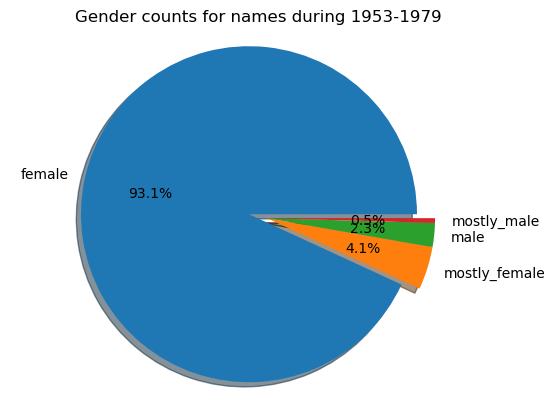

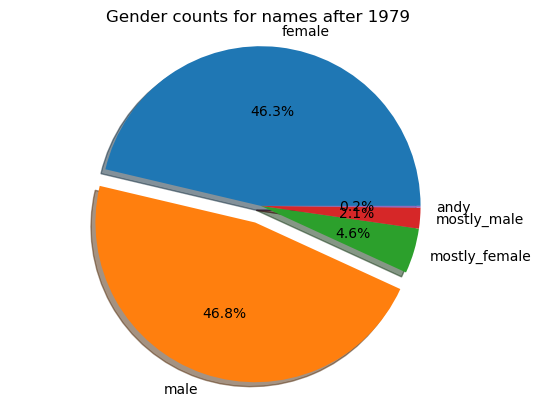

In [20]:
def plot_pie_chart(storms, period):
  # a function to plot pie chart the genders of names given a bunch of storms

  all_names = [str(name)[2:-1] for name in storms.name.values]
  all_names = [x for x in all_names if x!='NOT_NAMED'] # clean the unnamed cases
  print(f"In total there are {len(all_names)} named hurricanes {period}.\n")

  gender_lst = [d.get_gender(name) for name in all_names]
  gender_lst = [x for x in gender_lst if x!='unknown'] # clean the unknown names

  # Data (counts)
  genders_category = Counter(gender_lst).keys()  # equals to list(set(list))
  genders_count = Counter(gender_lst).values() # counts the elements' frequency
  explode = [0.11 if x==max(genders_count) else 0 for x in genders_count]

  # plot
  fig1, ax1 = plt.subplots()
  ax1.pie(genders_count, explode=explode, labels=genders_category, autopct='%1.1f%%',
          shadow=True, startangle=0)
  ax1.axis('equal')
  ax1.title.set_text(f'Gender counts for names {period}')



d = gender.Detector(case_sensitive=False)
gen = d.get_gender("Ophelia")
print(f"Ophelia is deemed a {gen} name.\n")
storms = tks.where((tks.season >=1953)&(tks.season <=1979), drop=True)
storms_1 = tks.where((tks.season >=1979), drop=True)

plot_pie_chart(storms, period='during 1953-1979')
plot_pie_chart(storms_1, period='after 1979')


### 3.5.3 Not all systems are hurricanes. Classification of systems - hurricane? tropical storm? tropical depression? 

Below codes summarize the types of all the classified hurricanes in the record (in the NA basin).

Storm classification by usa_status (according the documentation this is not the unique way of classifying the tracks)

Status of system. Options:
* DB - disturbance,
* TD - tropical depression,
* TS - tropical storm,
* TY - typhoon,
* ST - super typhoon,
* TC - tropical cyclone,
* HU,HR - hurricane,
* SD - subtropical depression,
* SS - subtropical storm,
* EX - extratropical systems,
* PT - post tropical,
* IN - inland,
* DS - dissipating,
* LO - low,
* WV - tropical wave,
* ET - extrapolated,
* MD - monsoon depression,
* XX - unknown.
 
documentation at https://www.ncei.noaa.gov/sites/default/files/2021-07/IBTrACS_v04_column_documentation.pdf

In [21]:
all_types = tks.usa_status.values
print(np.shape(all_types))

(2344, 360)


Notice the shape is (2344, 360), indicating that the classification of each system evolves along the 'date_time' axis. \
To identify a class for system across its whole track, we can define it as the one class that has the highest frequency throughout its lifetime.


There are 2002 systems in the North Atlantic that were classified at least once during its lifetime.



Text(0.5, 1.0, 'Counts of the classification of all the tracks')

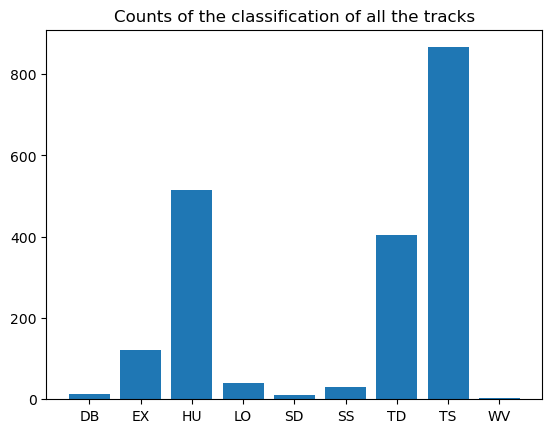

In [22]:
class_lst = []

for i in range(tks.dims['storm']):
  types = [str(x)[2:-1] for x in all_types[i]]
  types = [x for x in types if x!='']
  # many of the recorded tracks are never given a class
  if len(types)==0: continue
  class_category = Counter(types).most_common(1)[0][0] # Select the most frequent class
  class_lst.append(class_category)

print(f'There are {len(class_lst)} systems in the North Atlantic that were classified at \
least once during its lifetime.\n')

# This helps center the labels.
labels, counts = np.unique(class_lst, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.title('Counts of the classification of all the tracks')

# References

+ Nakamura, Jennifer, et al. "Classifying North Atlantic tropical cyclone tracks by mass moments." Journal of Climate 22.20 (2009): [5481-5494](https://journals.ametsoc.org/configurable/content/journals$002fclim$002f22$002f20$002f2009jcli2828.1.xml?t:ac=journals%24002fclim%24002f22%24002f20%24002f2009jcli2828.1.xml).

+ Nakamura, Jennifer, et al. "Western North Pacific tropical cyclone model tracks in present and future climates." Journal of Geophysical Research: Atmospheres 122.18 (2017): [9721-9744](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017JD027007).

In [27]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import xarray as xr
import numpy as np
import warnings
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd
warnings.filterwarnings('ignore')

In [28]:
### 2.1 Helper Functions and Setup
def map_background(label=False, extent=[-100, 0, 0, 60]):
    """Creates a map background for plotting hurricane tracks.
    
    Args:
        label (bool): Whether to show grid labels
        extent (list): Map boundaries [lon_min, lon_max, lat_min, lat_max]
    """
    plt.figure(figsize=(20, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent(extent)
    ax.gridlines(draw_labels=label)
    
    LAND = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                      edgecolor='face',
                                      facecolor=cfeature.COLORS['land'],
                                      linewidth=.1)
    OCEAN = cfeature.NaturalEarthFeature('physical', 'ocean', '10m',
                                       edgecolor='face',
                                       facecolor=cfeature.COLORS['water'], 
                                       linewidth=.1)
    ax.add_feature(LAND, zorder=0)
    ax.add_feature(OCEAN)
    return ax

def get_moments(storm):
    """Calculate mass moments for a storm track following Nakamura methodology.
    
    Args:
        storm: xarray Dataset containing storm track data
        
    Returns:
        list: [lon_centroid, lat_centroid, lon_var, lat_var, xy_var]
    """
    lon_lst = storm.lon.values[~np.isnan(storm.lon.values)]
    lat_lst = storm.lat.values[~np.isnan(storm.lat.values)]
    
    if len(lon_lst) <= 1:
        return None
        
    # First moment (centroid)
    lon_weighted = np.mean(lon_lst)
    lat_weighted = np.mean(lat_lst)
    
    # Second moment (covariance)
    cv = np.ma.cov([lon_lst, lat_lst])
    
    return [lon_weighted, lat_weighted, cv[0,0], cv[1,1], cv[0,1]]

In [29]:

### 2.2 Data Preparation and Initial Analysis
# Load and process hurricane track data
tks = xr.open_dataset('data/NA_data.nc', engine="netcdf4", decode_times=False)

# Calculate moments for all storms
moment_lst = [get_moments(tks.sel(storm=i)) for i in range(tks.dims['storm'])
              if get_moments(tks.sel(storm=i))]

print(f"Total number of tracks analyzed: {len(moment_lst)}")
print(f"Number of tracks excluded (too short): {tks.dims['storm']-len(moment_lst)}")

# Convert to numpy array for clustering
moment_array = np.array(moment_lst)

# Standardize features
scaler = StandardScaler()
moment_array_normalized = scaler.fit_transform(moment_array)

Total number of tracks analyzed: 2315
Number of tracks excluded (too short): 29


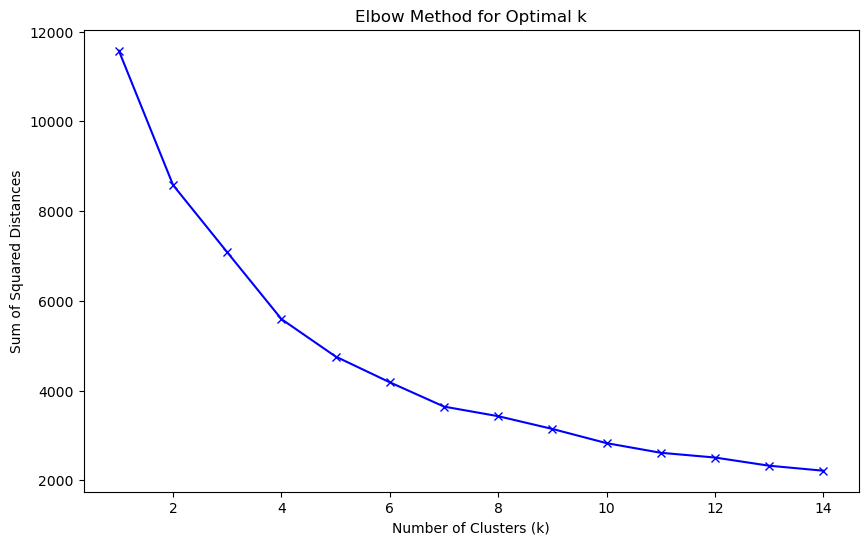

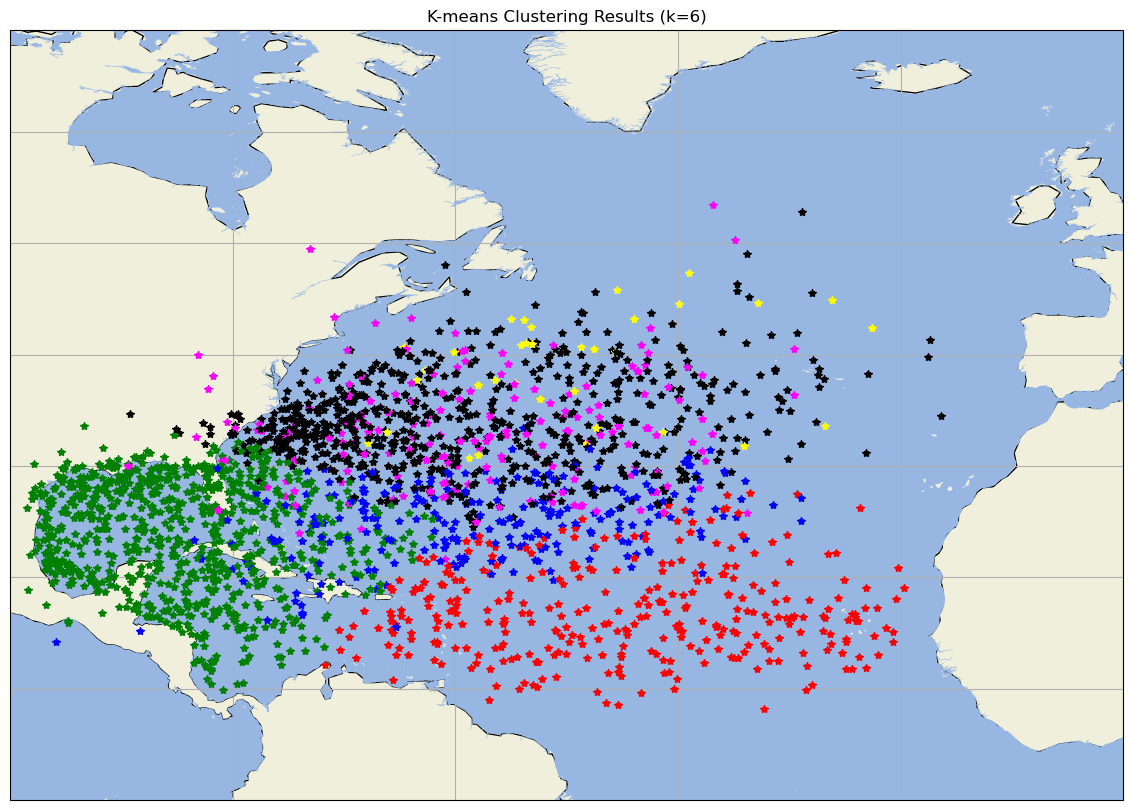

In [30]:

### 2.3 K-means Clustering Analysis
# Determine optimal number of clusters
sum_of_squares = []
K = range(1, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(moment_array_normalized)
    sum_of_squares.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squares, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k')
plt.show()

# Perform K-means clustering with optimal k=6
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_labels = kmeans.fit_predict(moment_array_normalized)

# Visualize K-means clusters
colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta']
ax = map_background()
for k in range(len(moment_array)):
    ax.plot(moment_array[k][0], moment_array[k][1], 
            c=colors[kmeans_labels[k]], marker='*')
plt.title('K-means Clustering Results (k=6)')
plt.show()

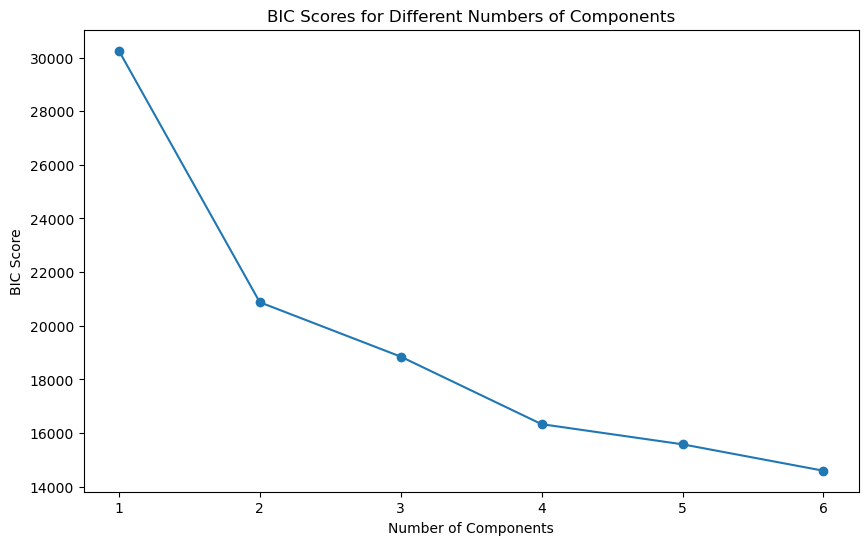

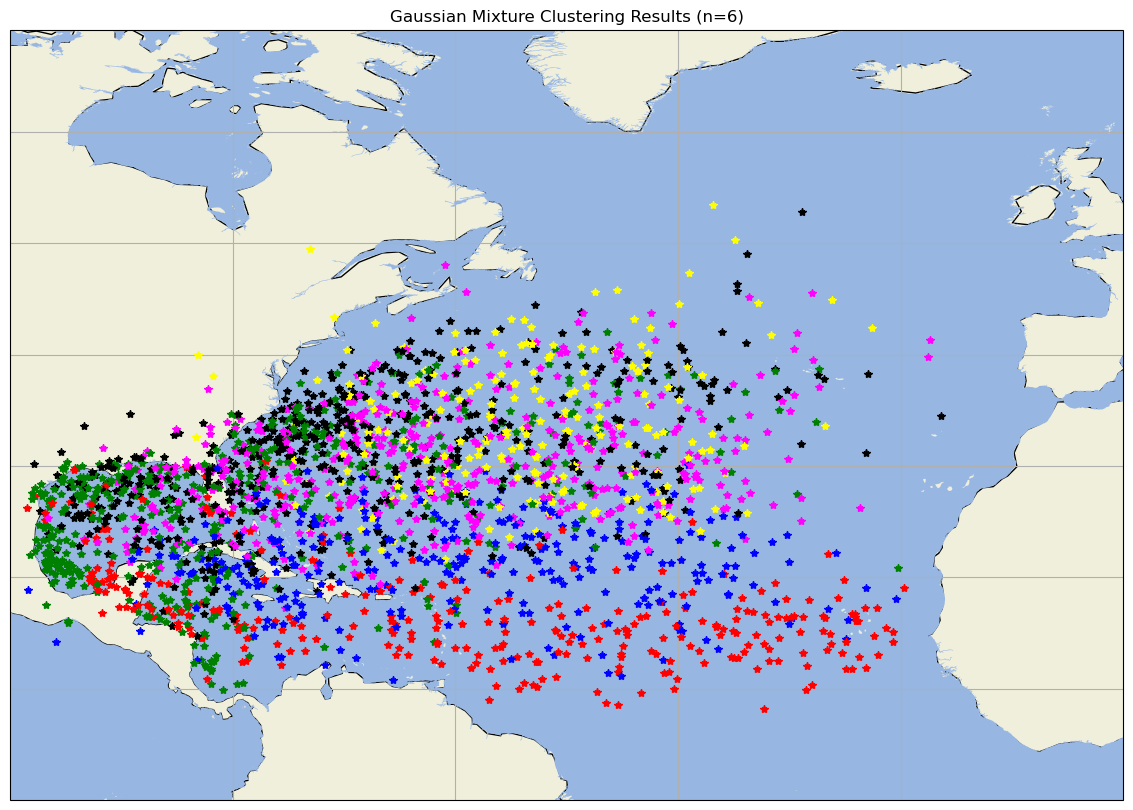

In [31]:
### 2.4 Gaussian Mixture Model Analysis
# Determine optimal number of components using BIC
n_components_range = range(1, 7)
bic = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, 
                         covariance_type='full', 
                         random_state=42)
    gmm.fit(moment_array_normalized)
    bic.append(gmm.bic(moment_array_normalized))

# Plot BIC scores
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.title('BIC Scores for Different Numbers of Components')
plt.show()

# Fit GMM with optimal components
optimal_n = n_components_range[np.argmin(bic)]
gmm = GaussianMixture(n_components=optimal_n, 
                      covariance_type='full', 
                      random_state=42)
gmm_labels = gmm.fit_predict(moment_array_normalized)

# Visualize GMM clusters
ax = map_background()
for k in range(len(moment_array)):
    ax.plot(moment_array[k][0], moment_array[k][1], 
            c=colors[gmm_labels[k]], marker='*')
plt.title(f'Gaussian Mixture Clustering Results (n={optimal_n})')
plt.show()

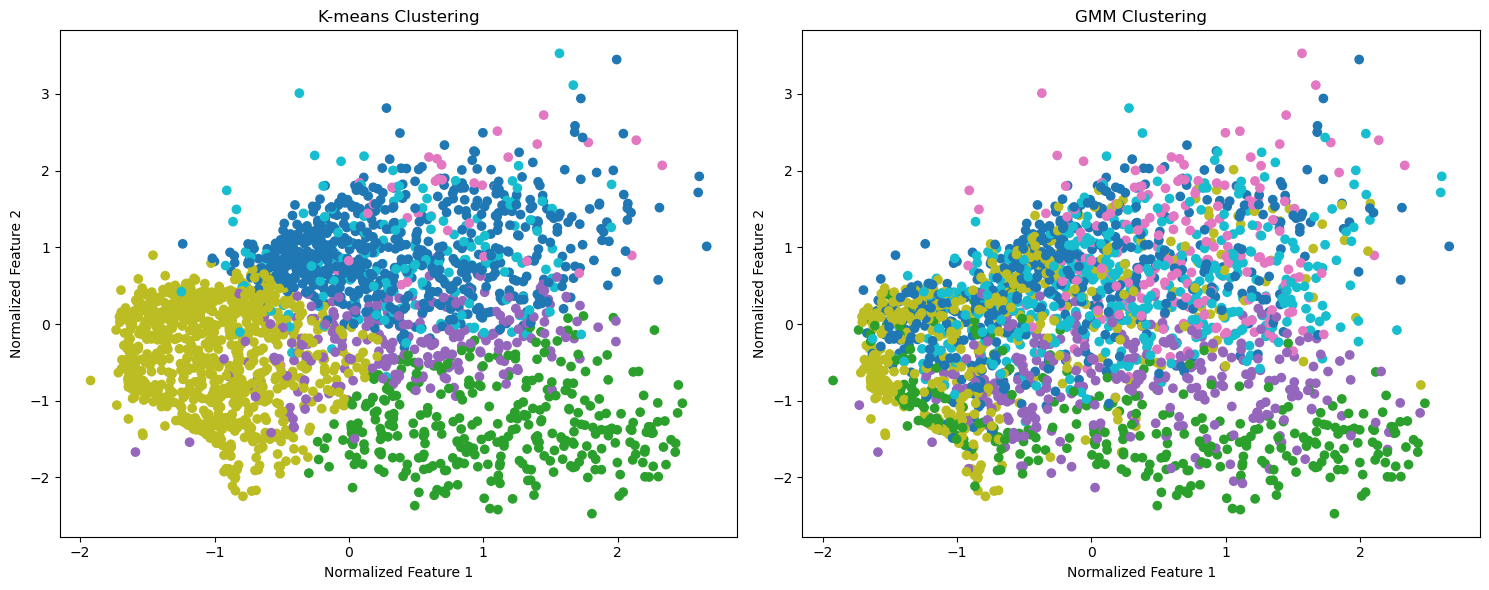

K-means Silhouette Score: 0.324
GMM Silhouette Score: 0.040


In [32]:
### 2.5 Clustering Comparison
# Compare cluster assignments between methods
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot normalized data colored by KMeans clusters
scatter1 = ax1.scatter(moment_array_normalized[:, 0], 
                      moment_array_normalized[:, 1],
                      c=kmeans_labels, 
                      cmap='tab10')
ax1.set_title('K-means Clustering')
ax1.set_xlabel('Normalized Feature 1')
ax1.set_ylabel('Normalized Feature 2')

# Plot normalized data colored by GMM clusters
scatter2 = ax2.scatter(moment_array_normalized[:, 0], 
                      moment_array_normalized[:, 1],
                      c=gmm_labels, 
                      cmap='tab10')
ax2.set_title('GMM Clustering')
ax2.set_xlabel('Normalized Feature 1')
ax2.set_ylabel('Normalized Feature 2')

plt.tight_layout()
plt.show()

# Calculate silhouette scores for both methods
from sklearn.metrics import silhouette_score

kmeans_silhouette = silhouette_score(moment_array_normalized, kmeans_labels)
gmm_silhouette = silhouette_score(moment_array_normalized, gmm_labels)

print(f"K-means Silhouette Score: {kmeans_silhouette:.3f}")
print(f"GMM Silhouette Score: {gmm_silhouette:.3f}")

In [33]:
# Calculate cluster probabilities from GMM
cluster_probs = gmm.predict_proba(moment_array_normalized)

# Calculate maximum probability for each point
max_probs = np.max(cluster_probs, axis=1)

# Print summary statistics
print("GMM Cluster Assignment Probabilities:")
print(f"Mean max probability: {np.mean(max_probs):.3f}")
print(f"Median max probability: {np.median(max_probs):.3f}")
print(f"Std of max probability: {np.std(max_probs):.3f}")

# Calculate alternative metrics
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

print("\nAlternative Clustering Metrics:")
print("Calinski-Harabasz Score (higher is better)")
print(f"K-means: {calinski_harabasz_score(moment_array_normalized, kmeans_labels):.3f}")
print(f"GMM: {calinski_harabasz_score(moment_array_normalized, gmm_labels):.3f}")

print("\nDavies-Bouldin Score (lower is better)")
print(f"K-means: {davies_bouldin_score(moment_array_normalized, kmeans_labels):.3f}")
print(f"GMM: {davies_bouldin_score(moment_array_normalized, gmm_labels):.3f}")

GMM Cluster Assignment Probabilities:
Mean max probability: 0.918
Median max probability: 0.979
Std of max probability: 0.126

Alternative Clustering Metrics:
Calinski-Harabasz Score (higher is better)
K-means: 816.090
GMM: 344.707

Davies-Bouldin Score (lower is better)
K-means: 1.110
GMM: 2.169


In [34]:
# 1. Compare cluster sizes
print("\nCluster Size Distribution:")
print("K-means clusters:")
for i in range(6):
    print(f"Cluster {i}: {np.sum(kmeans_labels == i)} tracks")
print("\nGMM clusters:")
for i in range(6):
    print(f"Cluster {i}: {np.sum(gmm_labels == i)} tracks")

# 2. Compare within-cluster variances
def get_cluster_variance(data, labels, cluster_id):
    cluster_points = data[labels == cluster_id]
    return np.mean(np.var(cluster_points, axis=0))

print("\nWithin-cluster Variances:")
print("K-means clusters:")
for i in range(6):
    var = get_cluster_variance(moment_array_normalized, kmeans_labels, i)
    print(f"Cluster {i}: {var:.3f}")
print("\nGMM clusters:")
for i in range(6):
    var = get_cluster_variance(moment_array_normalized, gmm_labels, i)
    print(f"Cluster {i}: {var:.3f}")


Cluster Size Distribution:
K-means clusters:
Cluster 0: 662 tracks
Cluster 1: 328 tracks
Cluster 2: 252 tracks
Cluster 3: 36 tracks
Cluster 4: 853 tracks
Cluster 5: 184 tracks

GMM clusters:
Cluster 0: 533 tracks
Cluster 1: 311 tracks
Cluster 2: 306 tracks
Cluster 3: 215 tracks
Cluster 4: 494 tracks
Cluster 5: 456 tracks

Within-cluster Variances:
K-means clusters:
Cluster 0: 0.248
Cluster 1: 0.213
Cluster 2: 0.548
Cluster 3: 4.804
Cluster 4: 0.186
Cluster 5: 0.722

GMM clusters:
Cluster 0: 0.295
Cluster 1: 0.371
Cluster 2: 0.541
Cluster 3: 2.569
Cluster 4: 0.285
Cluster 5: 0.426


In [35]:
# Check time range of data
years = np.unique(tks.season.values)
print(f"Data spans years: {min(years)} to {max(years)}")

# Check storm types/classifications
if 'usa_status' in tks:
    status_types = np.unique([str(x) for x in tks.usa_status.values.flatten() if str(x) != 'nan'])
    print("\nStorm classifications in data:")
    for status in status_types:
        print(f"- {status}")

# Count storms by intensity
if 'wind' in tks:
    max_winds = np.nanmax(tks.wind.values, axis=1)
    named_storm_threshold = 34  # knots
    print(f"\nStorms reaching named storm intensity: {np.sum(max_winds >= named_storm_threshold)}")
    print(f"Total tracks: {len(max_winds)}")

Data spans years: 1851.0 to 2023.0

Storm classifications in data:
- b''
- b'DB'
- b'ET'
- b'EX'
- b'HU'
- b'LO'
- b'SD'
- b'SS'
- b'TD'
- b'TS'
- b'WV'


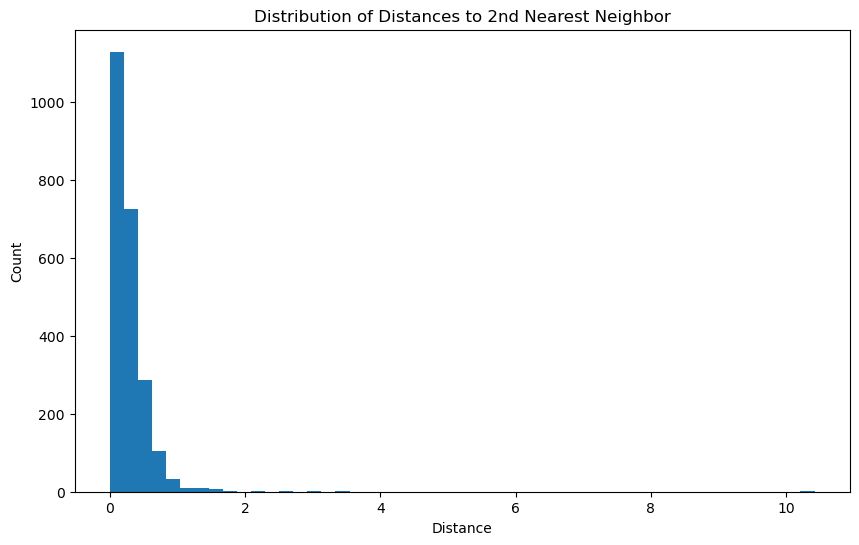

Distance statistics:
Mean distance: 0.286
Median distance: 0.214
75th percentile: 0.365

DBSCAN with eps=0.214
Number of clusters: 21
Number of noise points: 1506
Percentage of points classified as noise: 65.1%


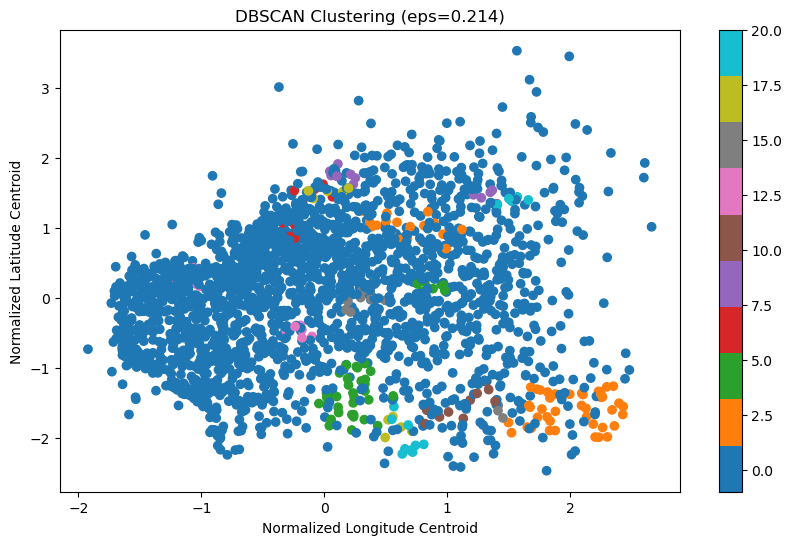


Cluster sizes:
Cluster 0: 602 points
Cluster 1: 14 points
Cluster 2: 44 points
Cluster 3: 25 points
Cluster 4: 33 points
Cluster 5: 7 points
Cluster 6: 8 points
Cluster 7: 5 points
Cluster 8: 5 points
Cluster 9: 8 points
Cluster 10: 5 points
Cluster 11: 5 points
Cluster 12: 6 points
Cluster 13: 5 points
Cluster 14: 10 points
Cluster 15: 3 points
Cluster 16: 5 points
Cluster 17: 5 points
Cluster 18: 6 points
Cluster 19: 3 points
Cluster 20: 5 points

DBSCAN with eps=0.252
Number of clusters: 11
Number of noise points: 1327
Percentage of points classified as noise: 57.3%


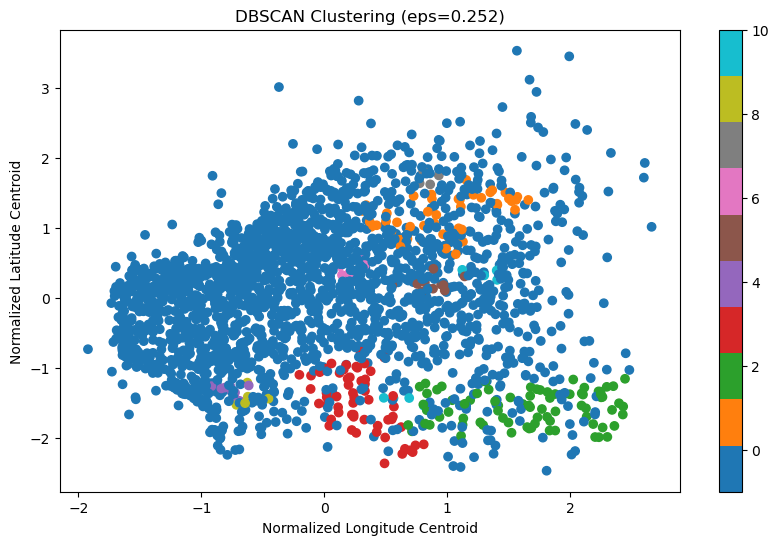


Cluster sizes:
Cluster 0: 756 points
Cluster 1: 51 points
Cluster 2: 80 points
Cluster 3: 58 points
Cluster 4: 11 points
Cluster 5: 10 points
Cluster 6: 5 points
Cluster 7: 4 points
Cluster 8: 5 points
Cluster 9: 4 points
Cluster 10: 4 points

DBSCAN with eps=0.289
Number of clusters: 11
Number of noise points: 1147
Percentage of points classified as noise: 49.5%


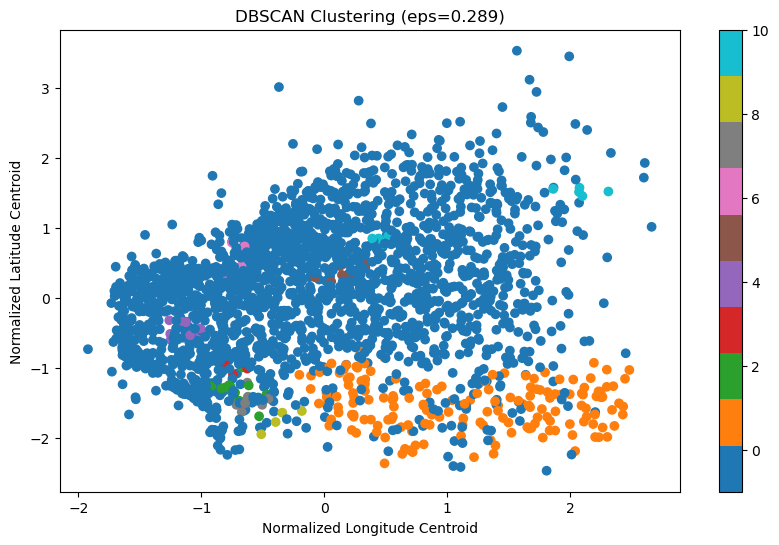


Cluster sizes:
Cluster 0: 935 points
Cluster 1: 171 points
Cluster 2: 15 points
Cluster 3: 3 points
Cluster 4: 9 points
Cluster 5: 8 points
Cluster 6: 6 points
Cluster 7: 7 points
Cluster 8: 4 points
Cluster 9: 5 points
Cluster 10: 5 points

DBSCAN with eps=0.327
Number of clusters: 4
Number of noise points: 986
Percentage of points classified as noise: 42.6%


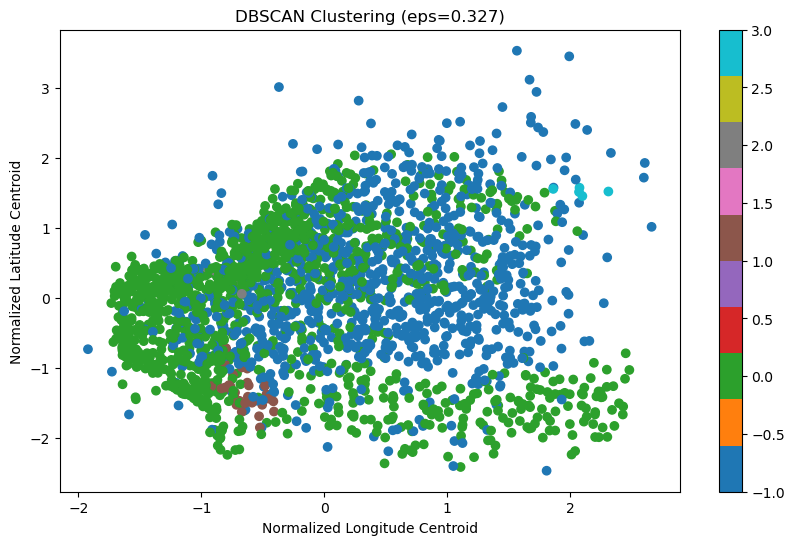


Cluster sizes:
Cluster 0: 1287 points
Cluster 1: 33 points
Cluster 2: 4 points
Cluster 3: 5 points

DBSCAN with eps=0.365
Number of clusters: 4
Number of noise points: 857
Percentage of points classified as noise: 37.0%


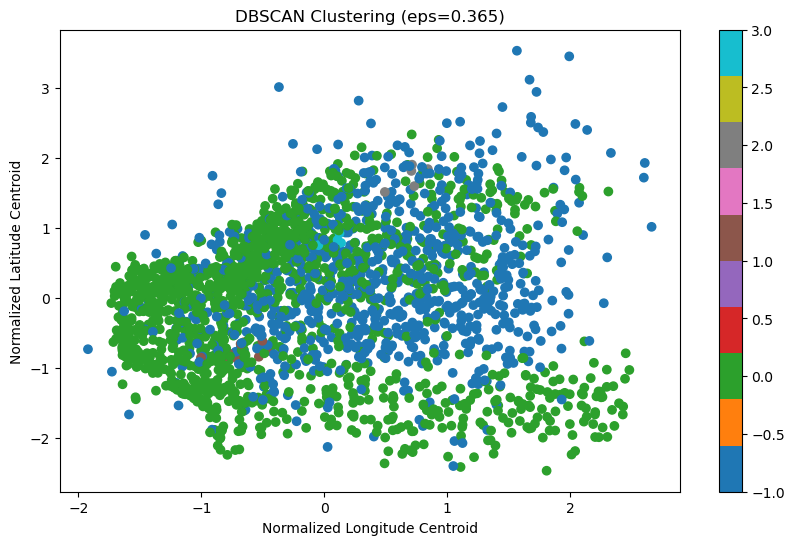


Cluster sizes:
Cluster 0: 1438 points
Cluster 1: 10 points
Cluster 2: 5 points
Cluster 3: 5 points


In [37]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# First, let's better understand the distance distribution in our data
neigh = NearestNeighbors(n_neighbors=5)  # increased to see more neighbors
nbrs = neigh.fit(moment_array_normalized)
distances, indices = nbrs.kneighbors(moment_array_normalized)

# Plot distances to nearest neighbors
plt.figure(figsize=(10, 6))
plt.hist(distances[:, 1], bins=50)  # Plot distance to 2nd nearest neighbor
plt.title('Distribution of Distances to 2nd Nearest Neighbor')
plt.xlabel('Distance')
plt.ylabel('Count')
plt.show()

print("Distance statistics:")
print(f"Mean distance: {np.mean(distances[:, 1]):.3f}")
print(f"Median distance: {np.median(distances[:, 1]):.3f}")
print(f"75th percentile: {np.percentile(distances[:, 1], 75):.3f}")

# Try a range of eps values based on the distance distribution
eps_values = np.linspace(np.median(distances[:, 1]), 
                        np.percentile(distances[:, 1], 75), 
                        5)

# Try DBSCAN with these more informed parameters
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(moment_array_normalized)
    
    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)
    
    print(f"\nDBSCAN with eps={eps:.3f}")
    print(f"Number of clusters: {n_clusters}")
    print(f"Number of noise points: {n_noise}")
    print(f"Percentage of points classified as noise: {(n_noise/len(dbscan_labels))*100:.1f}%")
    
    if n_clusters >= 2:  # Only plot if we have at least 2 clusters
        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(moment_array_normalized[:, 0], 
                            moment_array_normalized[:, 1], 
                            c=dbscan_labels, 
                            cmap='tab10')
        plt.title(f'DBSCAN Clustering (eps={eps:.3f})')
        plt.xlabel('Normalized Longitude Centroid')
        plt.ylabel('Normalized Latitude Centroid')
        plt.colorbar(scatter)
        plt.show()

        # Print cluster sizes
        unique_labels = set(dbscan_labels)
        print("\nCluster sizes:")
        for label in unique_labels:
            if label != -1:
                print(f"Cluster {label}: {np.sum(dbscan_labels == label)} points")


Testing rbf affinity:

Number of clusters: 4
Silhouette Score: 0.749


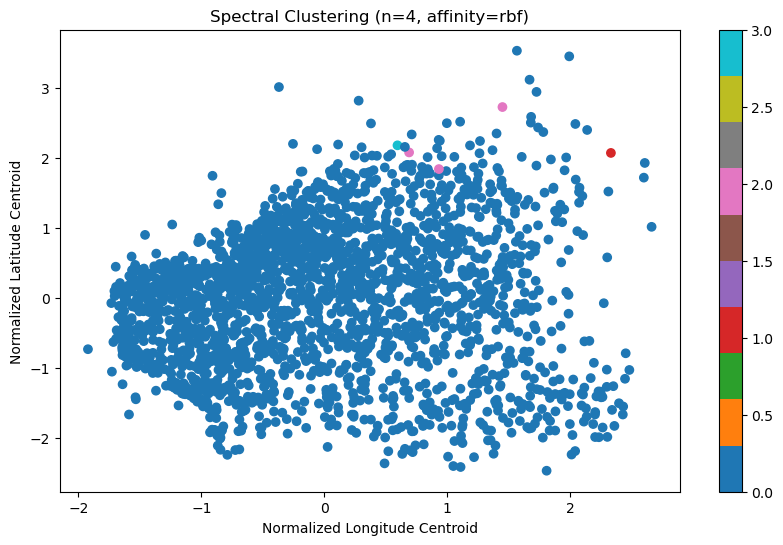


Cluster sizes:
Cluster 0: 2310 points
Cluster 1: 1 points
Cluster 2: 3 points
Cluster 3: 1 points

Number of clusters: 5
Silhouette Score: 0.703


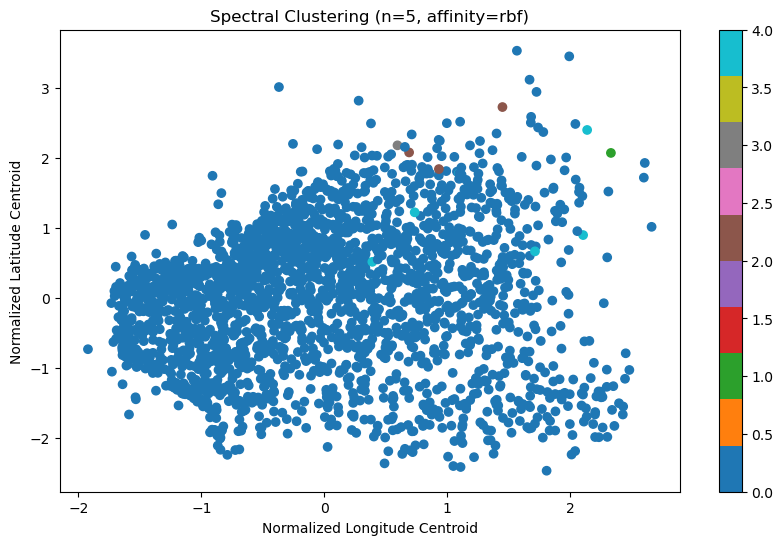


Cluster sizes:
Cluster 0: 2304 points
Cluster 1: 1 points
Cluster 2: 3 points
Cluster 3: 1 points
Cluster 4: 6 points

Number of clusters: 6
Silhouette Score: 0.640


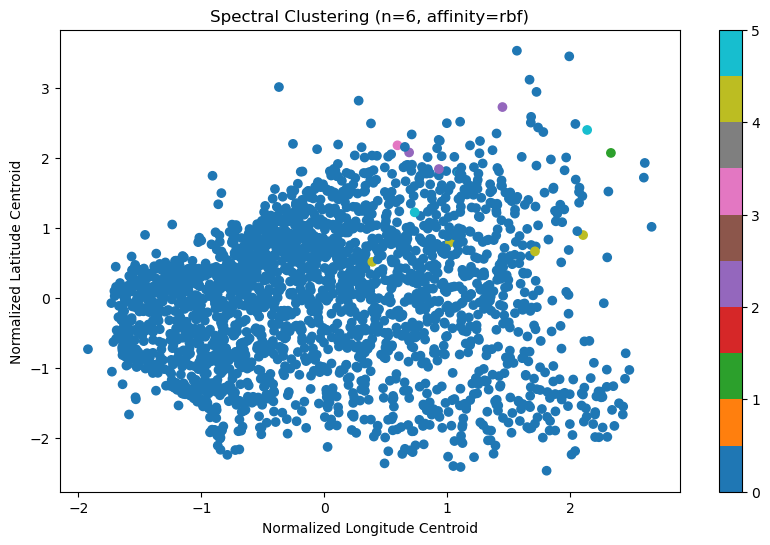


Cluster sizes:
Cluster 0: 2303 points
Cluster 1: 1 points
Cluster 2: 3 points
Cluster 3: 1 points
Cluster 4: 4 points
Cluster 5: 3 points

Number of clusters: 7
Silhouette Score: 0.610


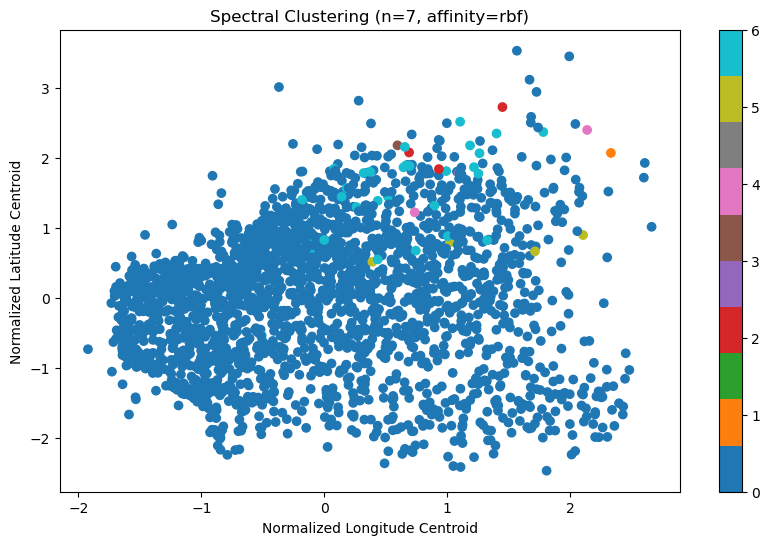


Cluster sizes:
Cluster 0: 2270 points
Cluster 1: 1 points
Cluster 2: 3 points
Cluster 3: 1 points
Cluster 4: 3 points
Cluster 5: 4 points
Cluster 6: 33 points

Number of clusters: 8
Silhouette Score: 0.605


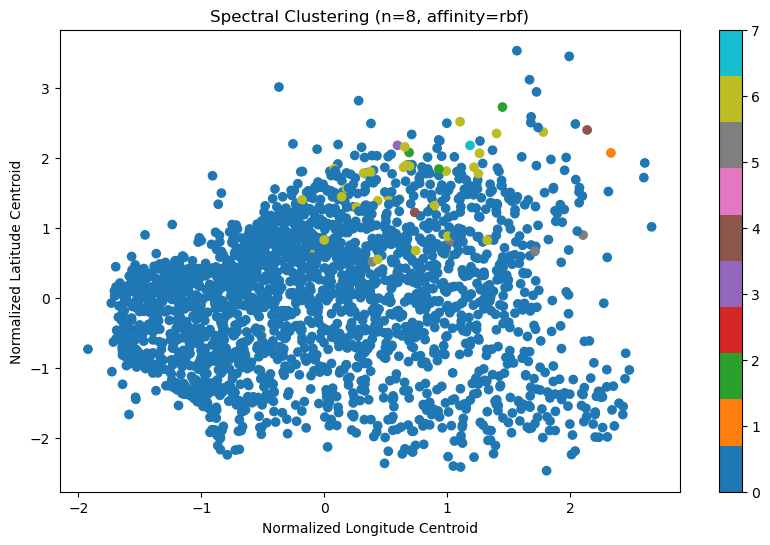


Cluster sizes:
Cluster 0: 2271 points
Cluster 1: 1 points
Cluster 2: 3 points
Cluster 3: 1 points
Cluster 4: 3 points
Cluster 5: 4 points
Cluster 6: 31 points
Cluster 7: 1 points

Testing nearest_neighbors affinity:

Number of clusters: 4
Silhouette Score: 0.113


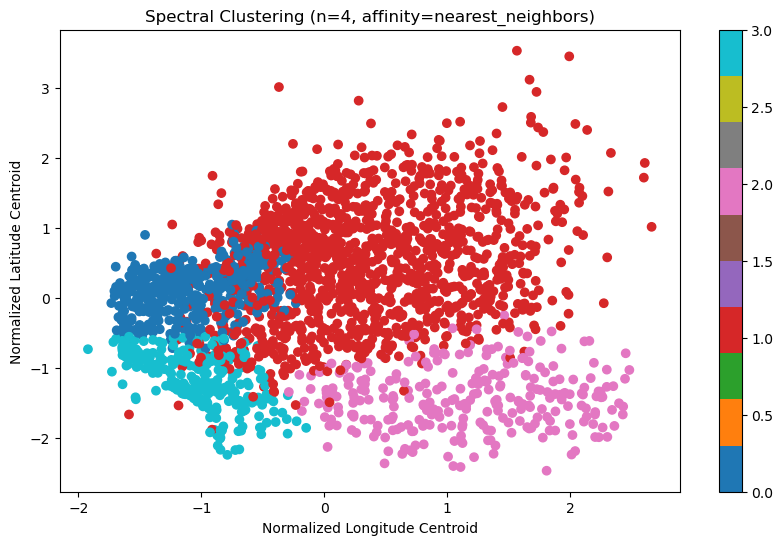


Cluster sizes:
Cluster 0: 445 points
Cluster 1: 1316 points
Cluster 2: 283 points
Cluster 3: 271 points

Number of clusters: 5
Silhouette Score: 0.150


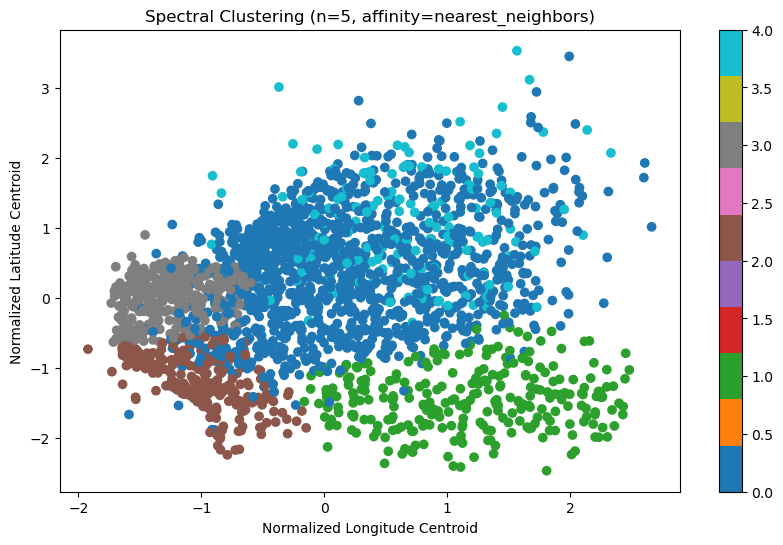


Cluster sizes:
Cluster 0: 1277 points
Cluster 1: 276 points
Cluster 2: 252 points
Cluster 3: 339 points
Cluster 4: 171 points

Number of clusters: 6
Silhouette Score: 0.177


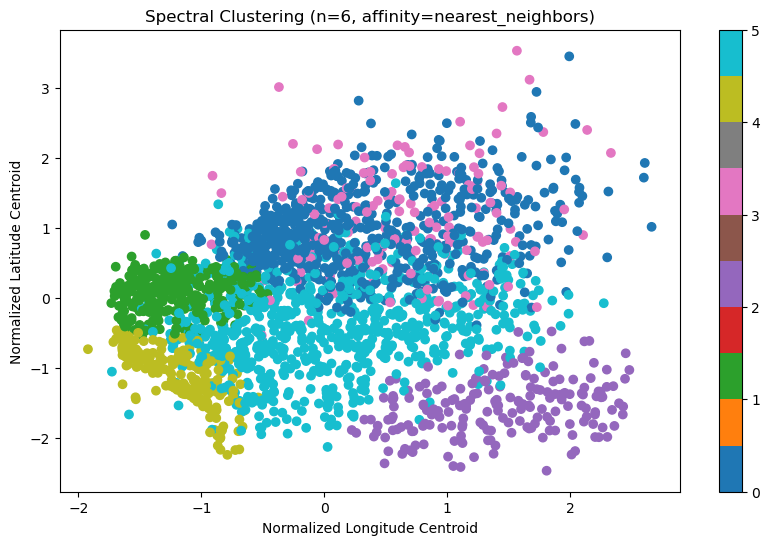


Cluster sizes:
Cluster 0: 668 points
Cluster 1: 330 points
Cluster 2: 198 points
Cluster 3: 158 points
Cluster 4: 206 points
Cluster 5: 755 points

Number of clusters: 7
Silhouette Score: 0.154


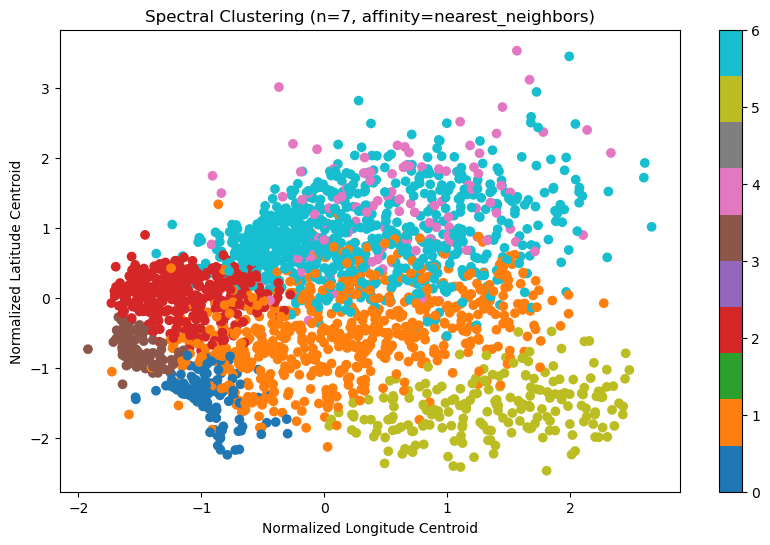


Cluster sizes:
Cluster 0: 112 points
Cluster 1: 637 points
Cluster 2: 381 points
Cluster 3: 106 points
Cluster 4: 125 points
Cluster 5: 205 points
Cluster 6: 749 points

Number of clusters: 8
Silhouette Score: 0.137


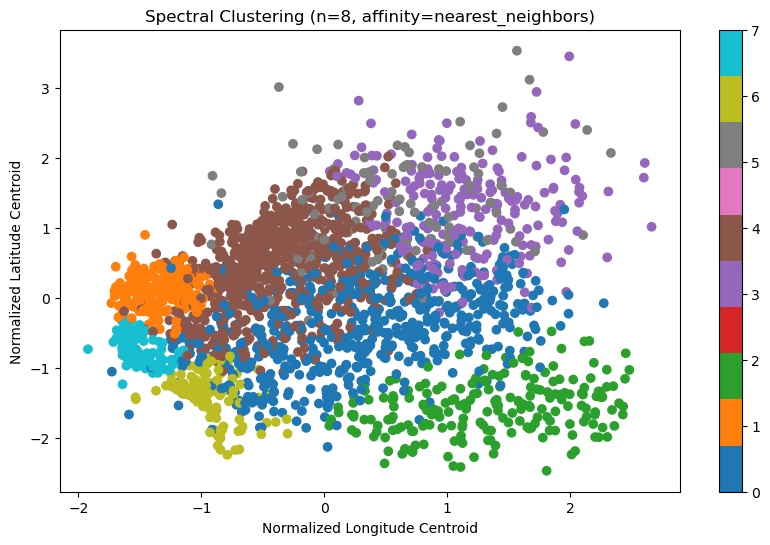


Cluster sizes:
Cluster 0: 594 points
Cluster 1: 218 points
Cluster 2: 209 points
Cluster 3: 233 points
Cluster 4: 717 points
Cluster 5: 127 points
Cluster 6: 111 points
Cluster 7: 106 points


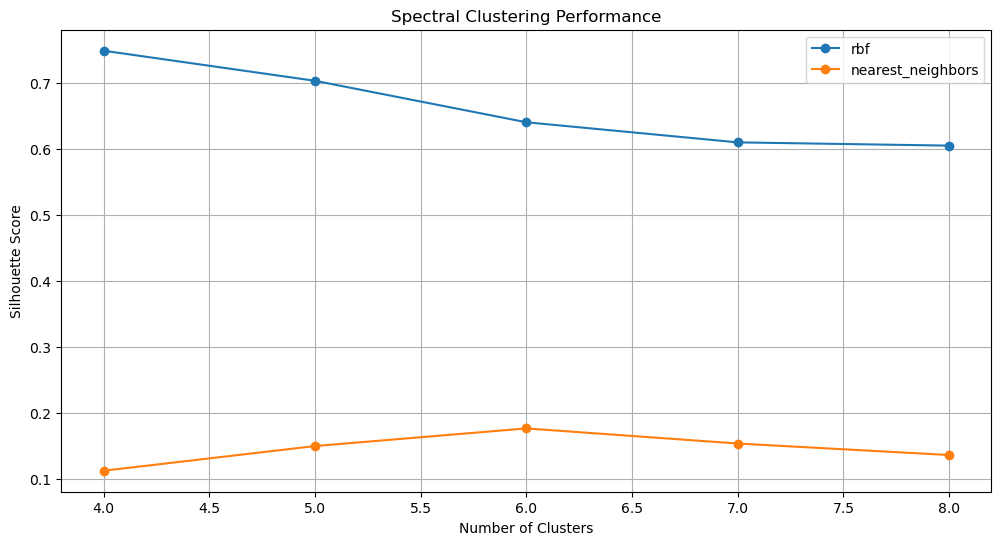


Clustering Comparison:
K-means Silhouette Score: 0.324
GMM Silhouette Score: 0.040
Best Spectral Silhouette Score: 0.749
(using rbf affinity and 4 clusters)


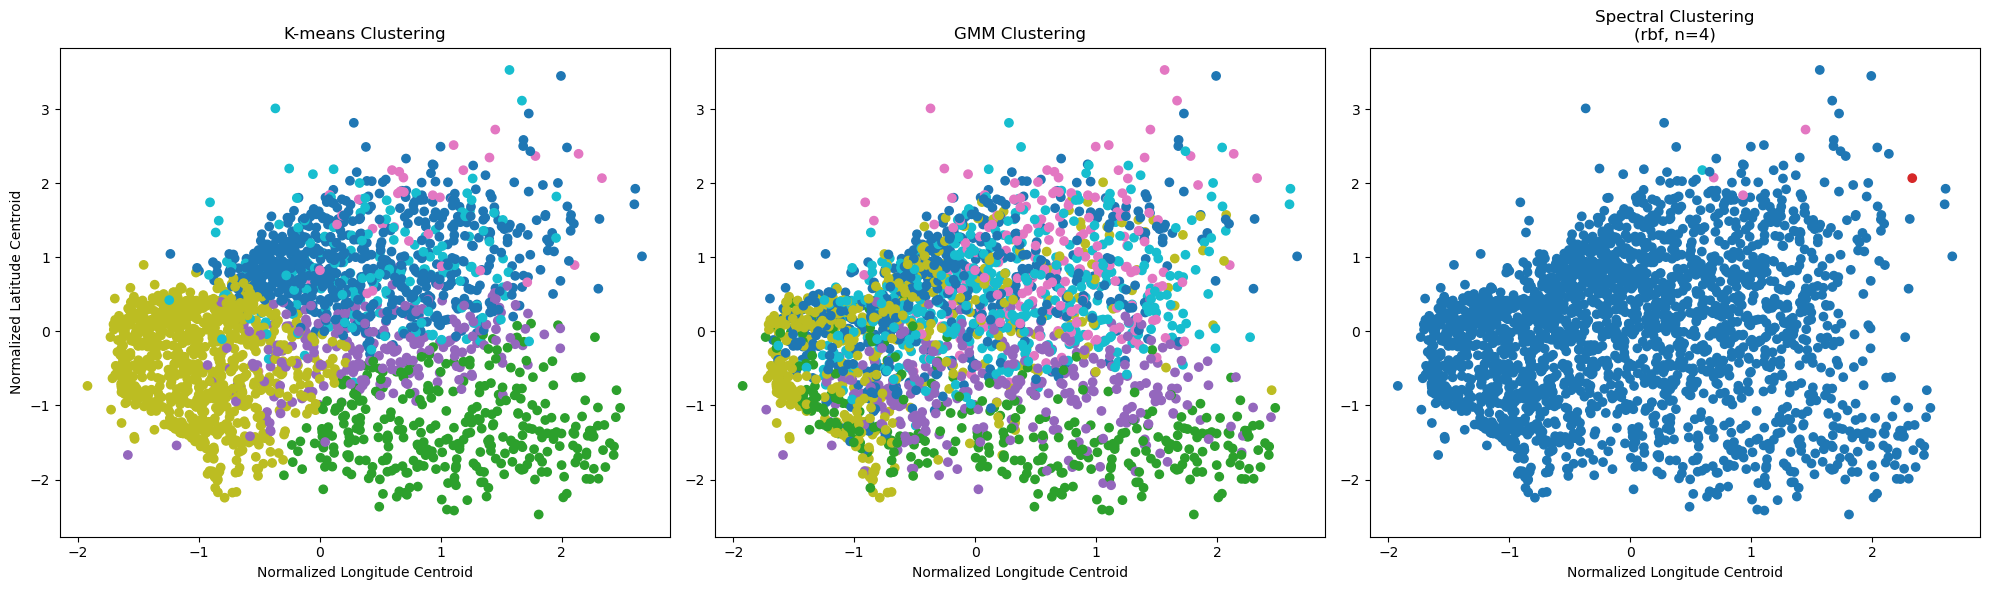

In [38]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Try different numbers of clusters and affinity metrics
n_clusters_range = [4, 5, 6, 7, 8]  # Including original K=6 from paper
affinity_types = ['rbf', 'nearest_neighbors']

results = {}

for affinity in affinity_types:
    print(f"\nTesting {affinity} affinity:")
    
    for n_clusters in n_clusters_range:
        # Fit Spectral Clustering
        spectral = SpectralClustering(n_clusters=n_clusters, 
                                    affinity=affinity,
                                    random_state=42)
        spectral_labels = spectral.fit_predict(moment_array_normalized)
        
        # Calculate silhouette score
        silhouette = silhouette_score(moment_array_normalized, spectral_labels)
        
        print(f"\nNumber of clusters: {n_clusters}")
        print(f"Silhouette Score: {silhouette:.3f}")
        
        # Store results
        results[(affinity, n_clusters)] = {
            'labels': spectral_labels,
            'silhouette': silhouette
        }
        
        # Plot clusters
        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(moment_array_normalized[:, 0], 
                            moment_array_normalized[:, 1],
                            c=spectral_labels, 
                            cmap='tab10')
        plt.title(f'Spectral Clustering (n={n_clusters}, affinity={affinity})')
        plt.xlabel('Normalized Longitude Centroid')
        plt.ylabel('Normalized Latitude Centroid')
        plt.colorbar(scatter)
        plt.show()
        
        # Print cluster sizes
        print("\nCluster sizes:")
        for i in range(n_clusters):
            print(f"Cluster {i}: {np.sum(spectral_labels == i)} points")

# Plot silhouette scores comparison
plt.figure(figsize=(12, 6))
for affinity in affinity_types:
    scores = [results[(affinity, n)]['silhouette'] for n in n_clusters_range]
    plt.plot(n_clusters_range, scores, 'o-', label=affinity)

plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Spectral Clustering Performance')
plt.legend()
plt.grid(True)
plt.show()

# Compare best spectral result with K-means and GMM
best_affinity, best_n = max(results.items(), key=lambda x: x[1]['silhouette'])[0]
best_spectral_labels = results[(best_affinity, best_n)]['labels']

print("\nClustering Comparison:")
print(f"K-means Silhouette Score: {silhouette_score(moment_array_normalized, kmeans_labels):.3f}")
print(f"GMM Silhouette Score: {silhouette_score(moment_array_normalized, gmm_labels):.3f}")
print(f"Best Spectral Silhouette Score: {silhouette_score(moment_array_normalized, best_spectral_labels):.3f}")
print(f"(using {best_affinity} affinity and {best_n} clusters)")

# Plot best clustering results side by side
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# K-means
scatter = axes[0].scatter(moment_array_normalized[:, 0], 
                         moment_array_normalized[:, 1],
                         c=kmeans_labels, 
                         cmap='tab10')
axes[0].set_title('K-means Clustering')
axes[0].set_xlabel('Normalized Longitude Centroid')
axes[0].set_ylabel('Normalized Latitude Centroid')

# GMM
scatter = axes[1].scatter(moment_array_normalized[:, 0], 
                         moment_array_normalized[:, 1],
                         c=gmm_labels, 
                         cmap='tab10')
axes[1].set_title('GMM Clustering')
axes[1].set_xlabel('Normalized Longitude Centroid')

# Best Spectral
scatter = axes[2].scatter(moment_array_normalized[:, 0], 
                         moment_array_normalized[:, 1],
                         c=best_spectral_labels, 
                         cmap='tab10')
axes[2].set_title(f'Spectral Clustering\n({best_affinity}, n={best_n})')
axes[2].set_xlabel('Normalized Longitude Centroid')

plt.tight_layout()
plt.show()